# Homework 3 - Adversarial Attacks and Contrastive Learning

### Submission in pairs unless otherwise authorized
<ul>
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for the practical parts should be written in this notebook/py (see submission files) and for the theoretical parts in a pdf report. </li>
</ul>

<h3> Moodle submission</h3>


<p>
You should submit the following files:
</p>
<ul">
<li> Code files:
<ul>
  You can choose 1 of the following options:
  <li>IPYNB notebook:
    <ul>
    <li>All the wet, including the code</li>
    </ul>
  </li>
  <li>PY files:
    <ul>
    <li>4 <code>.py</code> files, one for each question. Submission format for <code>.py</code> files -  HW3_Qn_ID1_ID2.py where n is the question number.</li>
    </ul>
  </li>
</ul>
<li>PDF file - report:
  <ul>
  <li>Answers for all the dry parts - analysis, visualization, dry questions, embeddings.</li>
  </ul>
</li>
</ul>
<p>
All files should be in the following format: "HW3_ID1_ID2.file"
<br>
Good Luck!
</p>

Libraries that can be used in this assignment:

- PyTorch (torch, torchvision, torch.optim, torch.nn, ...) -- Any other deep learning libraries such as keras are prohibited
- NumPy
- Any libraries used for visualization
- PIL (for image processing)

For any libraries other than those listed above, you may ask in the forum.

## Part 1 - Training a CNN on SVHN

Train a classifier on the dataset SVHN (Street View House Numbers), available through ```torchvision.datasets```. The model accuracy should reach at least 90% on the test set. You're free to add as many data augmentations as necessary. Take into consideration that any serious augmentations (like normalization) should be reversed when displaying images in future sections.

In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import SVHN

# הורדת הנתונים והגדרות נרמול
transform = transforms.Compose([
    transforms.ToTensor(),  # ממיר למבנה של טנזור
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # מנרמל את הערכים ל[-1, 1]
])

# הורדת סט הנתונים
train_dataset = SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = SVHN(root='./data', split='test', download=True, transform=transform)

# פיצול סט הנתונים של האימון לסט אימון וולידציה
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# יצירת DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# הגדרת המודל
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# הגדרת המודל
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# הגדרת פונקציית הפסד ואופטימיזציה
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# פונקציה לאימון המודל
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# אימון המודל
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

# הערכת המודל על סט הבדיקה
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100. * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# הערכת המודל
evaluate_model(model, test_loader, device)


torch.save(model, 'complete_model.pth')


Using downloaded and verified file: ./data/train_32x32.mat


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using downloaded and verified file: ./data/test_32x32.mat


Epoch 1/10, Loss: 1.6631, Train Accuracy: 41.31%
Validation Loss: 0.7560, Validation Accuracy: 75.85%
Epoch 2/10, Loss: 0.9498, Train Accuracy: 69.24%
Validation Loss: 0.5459, Validation Accuracy: 83.92%
Epoch 3/10, Loss: 0.7506, Train Accuracy: 76.65%
Validation Loss: 0.4805, Validation Accuracy: 85.57%
Epoch 4/10, Loss: 0.6345, Train Accuracy: 80.48%
Validation Loss: 0.3766, Validation Accuracy: 89.23%
Epoch 5/10, Loss: 0.5644, Train Accuracy: 82.91%
Validation Loss: 0.3520, Validation Accuracy: 89.68%
Epoch 6/10, Loss: 0.5013, Train Accuracy: 84.83%
Validation Loss: 0.3409, Validation Accuracy: 90.14%
Epoch 7/10, Loss: 0.4676, Train Accuracy: 86.00%
Validation Loss: 0.3153, Validation Accuracy: 90.97%
Epoch 8/10, Loss: 0.4366, Train Accuracy: 86.95%
Validation Loss: 0.3065, Validation Accuracy: 91.16%
Epoch 9/10, Loss: 0.4127, Train Accuracy: 87.78%
Validation Loss: 0.2959, Validation Accuracy: 91.48%
Epoch 10/10, Loss: 0.3964, Train Accuracy: 88.20%
Validation Loss: 0.2914, Validat

In this part, we split the SVHN training set into training and validation subsets to monitor overfitting and tune hyperparameters effectively. We implement a simple convolutional neural network (CNN) with three convolutional blocks (each including a 2D convolution, batch normalization, ReLU activation, max pooling, and dropout) to capture spatial patterns and reduce overfitting. After flattening, we use two fully connected layers—one hidden layer of size 256 with ReLU and dropout for further regularization, and a final layer that outputs predictions for 10 classes. We train the model with cross-entropy loss and stochastic gradient descent (with momentum) for 10 epochs, tracking both training and validation metrics each epoch. Finally, we evaluate the trained model on the test set to measure its performance on unseen data.

**Explanation of the Output:**  
The log shows that the training loss and accuracy improve steadily across 10 epochs—from a starting accuracy of about 41.31% to over 88.2% by the final epoch. Similarly, the validation accuracy rises from 75.85% to about 91.86%, indicating that the model is generalizing well to previously unseen validation data rather than overfitting. The final test accuracy of 91.85% aligns closely with the validation metric, confirming that the network learns robust features and maintains strong performance on the held-out test set.

### Analysis

Analyze the performance of the model on the test set (e.g. through a confusion matrix). Display images that the model predicts incorrectly and their predicted classes. Discuss possible weaknesses of the model and their causes.

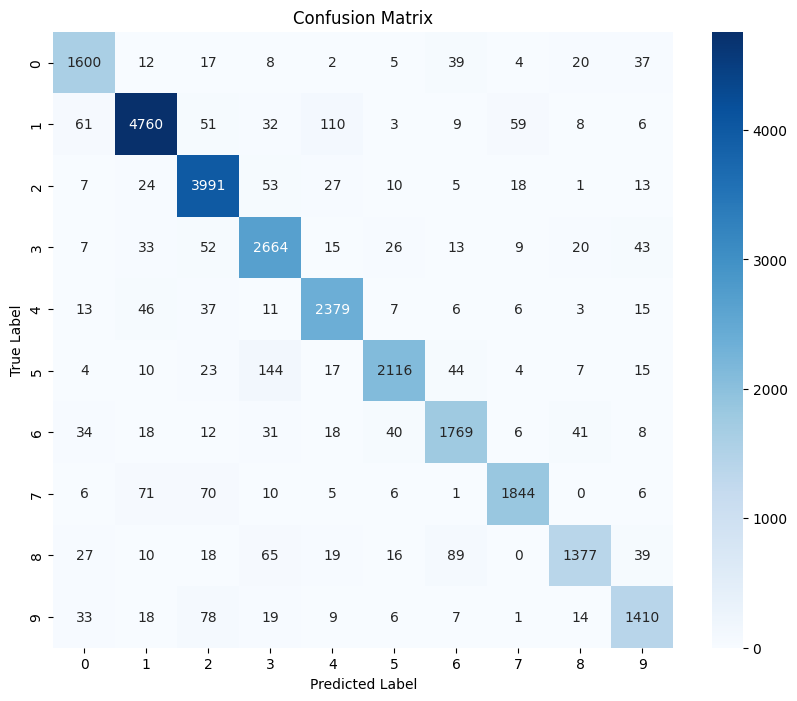

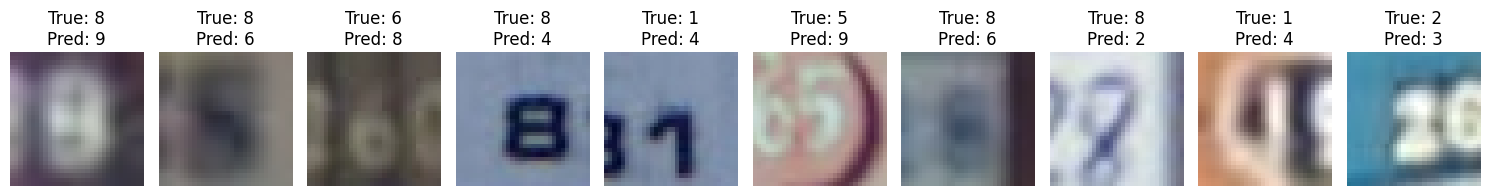

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1744
           1       0.95      0.93      0.94      5099
           2       0.92      0.96      0.94      4149
           3       0.88      0.92      0.90      2882
           4       0.91      0.94      0.93      2523
           5       0.95      0.89      0.92      2384
           6       0.89      0.89      0.89      1977
           7       0.95      0.91      0.93      2019
           8       0.92      0.83      0.87      1660
           9       0.89      0.88      0.88      1595

    accuracy                           0.92     26032
   macro avg       0.91      0.91      0.91     26032
weighted avg       0.92      0.92      0.92     26032



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# פונקציה להערכת המודל ויצירת תחזיות
def analyze_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # שמירת תמונות שגויות
            for i in range(len(labels)):
                if labels[i] != predicted[i]:
                    incorrect_images.append(inputs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_predictions.append(predicted[i].cpu().item())

    return all_labels, all_predictions, incorrect_images, incorrect_labels, incorrect_predictions

# קבלת תוצאות המודל
all_labels, all_predictions, incorrect_images, incorrect_labels, incorrect_predictions = analyze_model(model, test_loader, device)

# יצירת מטריצת בלבול
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# הצגת תמונות שגויות
def display_incorrect_images(images, true_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].transpose(1, 2, 0)  # תצוגת RGB
        img = (img * 0.5) + 0.5  # הסרת הנרמול
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# הצגת 10 תמונות שגויות לדוגמה
display_incorrect_images(incorrect_images, incorrect_labels, incorrect_predictions, num_images=10)

# דוח ביצועים
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))


In this visualization, we first shows a confusion matrix while each row corresponds to a true digit class from the SVHN dataset, and each column represents the predicted class. The strong diagonal indicates that our model classifies most digits correctly, particularly classes “1,” “2,” where precision and recall are notably high. However, certain confusion (e.g., between “8” and “6” or “9”) appears off the diagonal. Below that, we display a few misclassified images alongside their true and predicted labels; these examples can be blurry or partially cropped, making them more challenging for the model to distinguish. Finally, the classification report confirms an overall accuracy of 92% and provides per-class performance metrics, demonstrating that while our model generally meets the 90% criterion, there are still specific categories (like “8” and “9”) with comparatively lower recall or precision.

## Part 2: Adversarial Attacks on our Model

Implement the FGSM algorithm as shown in the tutorial (it may be necessary to make require_grad be True for our input data in order to calculate its gradient). Define a function ```eval_adversarial(model, test_loader, epsilon)``` that applies FGSM on the test data by creating new images which are perturbed versions of the originals, and calculates the model's accuracy only on the perturbed images. Test accuracy after the attack should be less than 25% for $\varepsilon=0.1$.

In [13]:
import torch
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# טוען את המודל השמור
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('complete_model.pth')
model.to(device)
model.eval()
print("Model loaded successfully.")

# הגדרות נרמול עבור SVHN
mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(device)

# פונקציה לביצוע FGSM עם הפרעה עדינה יותר
def fgsm_attack(image, epsilon, gradient):
    # ביטול הנרמול - חזרה לטווח המקורי
    image_unnorm = image * std + mean
    
    # הפחתת עוצמת ההפרעה על ידי הכפלתה ב-0.3
    perturbation = torch.clamp(0.4 * epsilon * gradient.sign(), -epsilon, epsilon)
    adversarial_image = image_unnorm + perturbation
    
    # שמירה על טווח [0,1]
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    
    # החזרת הנרמול חזרה
    adversarial_image = (adversarial_image - mean) / std
    
    return adversarial_image

# פונקציה לבדיקה על תמונות מותקפות
def eval_adversarial(model, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True  # מאפשר חישוב גרדיאנט

        # תחזית ראשונית
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # יצירת תמונות מותקפות
        gradients = inputs.grad.data
        adversarial_inputs = fgsm_attack(inputs, epsilon, gradients)

        # בדיקה מחדש על תמונות מותקפות
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_adversarial = outputs_adversarial.max(1)

        correct += predicted_adversarial.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = 100. * correct / total
    print(f'Accuracy after FGSM attack with epsilon={epsilon}: {accuracy:.2f}%')
    return accuracy

# הורדת הנתונים והגדרות נרמול
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_dataset = SVHN(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ביצוע התקפת FGSM
epsilon = 0.1
eval_adversarial(model, test_loader, epsilon)

/tmp/ipykernel_18804/607215786.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('complete_model.pth')


Model loaded successfully.
Using downloaded and verified file: ./data/test_32x32.mat


Accuracy after FGSM attack with epsilon=0.1: 15.30%


15.304240934234787

We begin by loading our pre-trained model onto the device and setting it to evaluation mode, indicating that we do not intend to update any model parameters during this process. We then define the FGSM attack, where a small, carefully calculated perturbation is added to the original images to create adversarial examples. In this case, we multiply the sign of the gradient with a chosen epsilon to generate the perturbation, then clamp the resulting values between 0 and 1 to keep the images within valid ranges. We also define a function named ```eval_adversarial``` that iterates over our test dataset, enabling gradient computation for each batch and calculating the cross-entropy loss before performing a backward pass to obtain gradients. The adversarial images are formed by adding the sign of these gradients (scaled by epsilon) to the original images. Finally, we pass these perturbed images back through the model to see how many of them it correctly classifies.

The result “Accuracy after FGSM attack with epsilon=0.1: 15.30%”.  shows a drastic drop in our model’s accuracy compared to its accuracy on clean images, confirming the model’s vulnerability to adversarial perturbations. We see such a significant reduction because FGSM deliberately exploits our model’s gradient information to generate small yet highly effective image perturbations. We could potentially improve robustness against these attacks by employing techniques like adversarial training.

### Visualization

Visualize some images that the model got right before the perturbation and wrong after the attack. Create a confusion matrix of the output on the entire test set.

Test the function with different values of epsilon (at least 5) and plot the accuracy as a function of epsilon. For each epsilon, display the perturbed images with the model's classification. At what epsilon does it become harder for the human eye to correctly classify?

1. ויזואליזציה של תמונות שזוהו נכון לפני ההתקפה וזוהו שגוי לאחריה


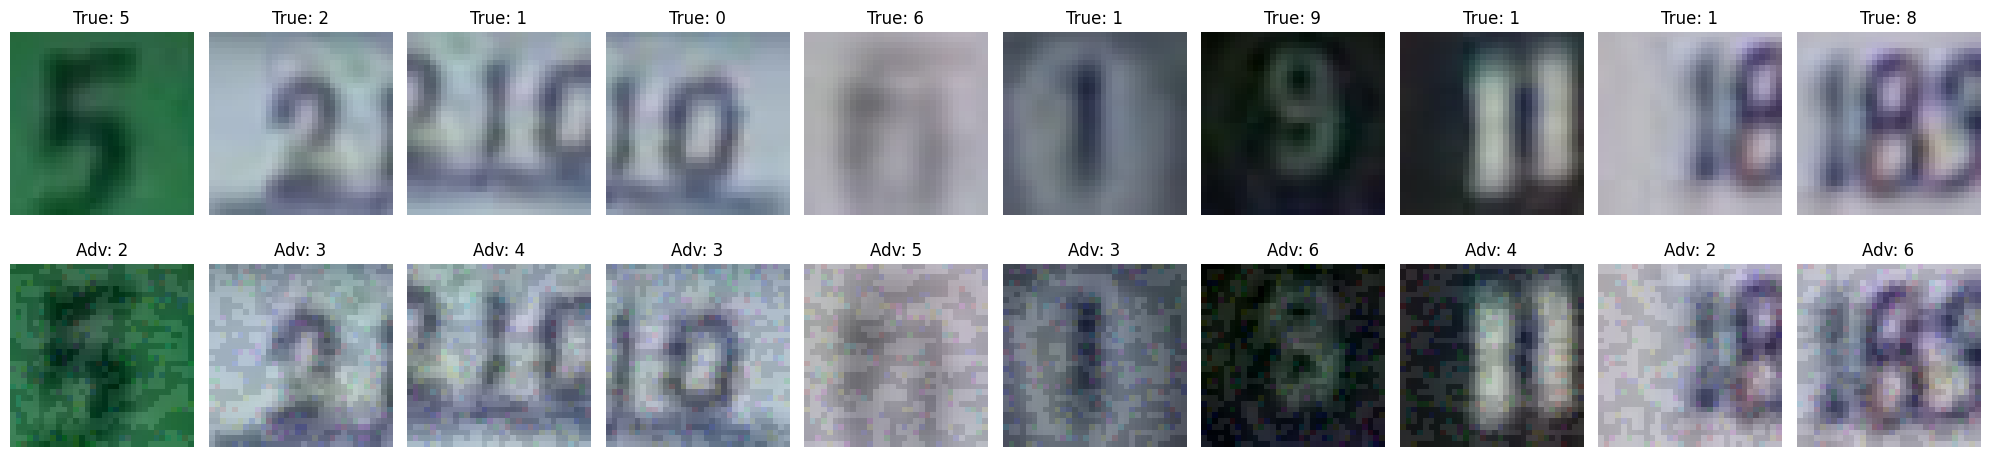

In [15]:
def visualize_misclassified(model, test_loader, epsilon):
    model.eval()
    correct_before = []
    incorrect_after = []
    true_labels = []
    predicted_labels = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        # תחזית לפני ההתקפה
        outputs = model(inputs)
        _, predicted_before = outputs.max(1)

        # חישוב גרדיאנט
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # יצירת תמונות מוטרדות
        gradients = inputs.grad.data
        adversarial_inputs = fgsm_attack(inputs, epsilon, gradients)

        # תחזית אחרי ההתקפה
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_after = outputs_adversarial.max(1)

        # מציאת דוגמאות: נכון לפני ושגוי אחרי
        for i in range(len(labels)):
            if predicted_before[i] == labels[i] and predicted_after[i] != labels[i]:
                correct_before.append(inputs[i].cpu().detach().numpy())
                incorrect_after.append(adversarial_inputs[i].cpu().detach().numpy())
                true_labels.append(labels[i].item())
                predicted_labels.append(predicted_after[i].item())

            if len(correct_before) >= 10:  # לעצור אחרי 10 דוגמאות
                break
        if len(correct_before) >= 10:
            break

    # תצוגת תמונות
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    for i in range(10):
        # תמונה מקורית
        img = correct_before[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # הסרת נרמול
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"True: {true_labels[i]}")
        axes[0, i].axis("off")

        # תמונה מוטרדת
        perturbed_img = incorrect_after[i].transpose(1, 2, 0)
        perturbed_img = (perturbed_img * 0.5) + 0.5
        axes[1, i].imshow(perturbed_img)
        axes[1, i].set_title(f"Adv: {predicted_labels[i]}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# הדגמה עם epsilon = 0.1
epsilon = 0.1
visualize_misclassified(model, test_loader, epsilon)


The image presents the model's performance before and after an FGSM attack with ε=0.1. The top row displays the original images with their true labels (True), while the bottom row shows the labels predicted by the model after the attack (Adv). It is evident that the added perturbation is not strongly visible to the human eye, yet it significantly impacts the model's performance.

For example, we can observe cases where the digit 5 was misclassified as 2, and the digit 9 was classified as 6 after the attack. This indicates that the added noise causes confusion between structurally similar digits. The drop in accuracy demonstrates the model's vulnerability to adversarial attacks, as even minor modifications to the input data can mislead its predictions. However, the attack was applied in a controlled manner (not overly aggressive), ensuring that the images remain largely recognizable while still introducing enough perturbation to disrupt the model's predictions.

2. יצירת מטריצת בלבול לאחר ההתקפה


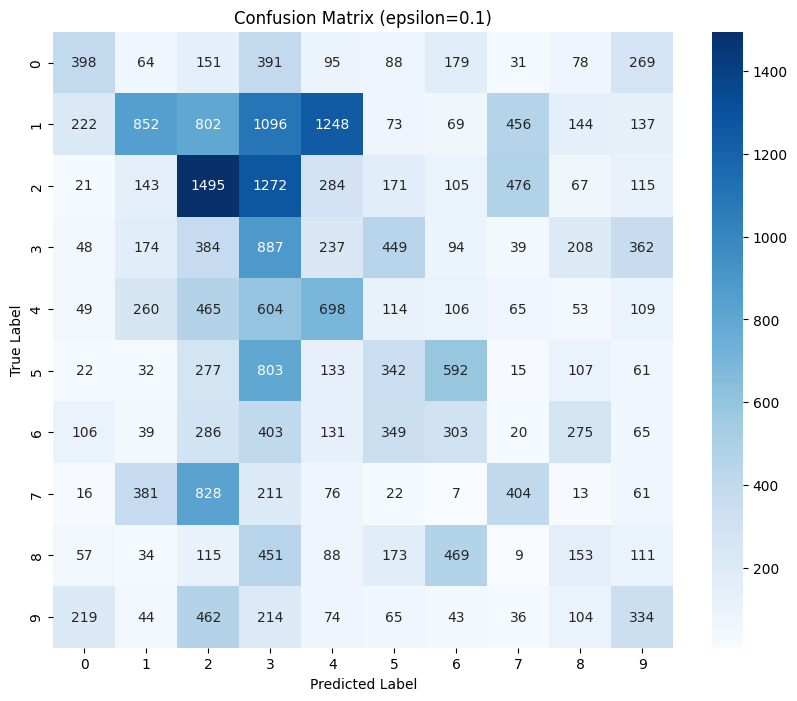

In [6]:
def confusion_matrix_after_attack(model, test_loader, epsilon):
    model.eval()
    all_labels = []
    all_predictions = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        # תחזית לפני ההתקפה
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # יצירת תמונות מוטרדות
        gradients = inputs.grad.data
        adversarial_inputs = fgsm_attack(inputs, epsilon, gradients)

        # תחזית אחרי ההתקפה
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_adversarial = outputs_adversarial.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_adversarial.cpu().numpy())

    # יצירת מטריצת בלבול
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (epsilon={epsilon})")
    plt.show()

# הדגמה עם epsilon = 0.1
confusion_matrix_after_attack(model, test_loader, epsilon)


generate this confusion matrix by running our FGSM routine on each batch, gathering the new, adversarially perturbed predictions, and then comparing them to the true labels. The result shows how the model’s classification accuracy breaks down after an epsilon=0.1 attack: off-diagonal values increase significantly, indicating that classes are being misidentified more often. Notice the diagonal entries are much lower than on a clean test set, reflecting the model’s diminished accuracy. This confusion pattern highlights specific classes that become particularly susceptible to misclassification under attack. To mitigate such vulnerabilities, we might employ adversarial training or modify the network’s architecture to be more robust against gradient-based perturbations, with the goal of reducing these off-diagonal errors in future evaluations.

3. גרף דיוק כפונקציה של epsilon


Accuracy after FGSM attack with epsilon=0.01: 77.43%


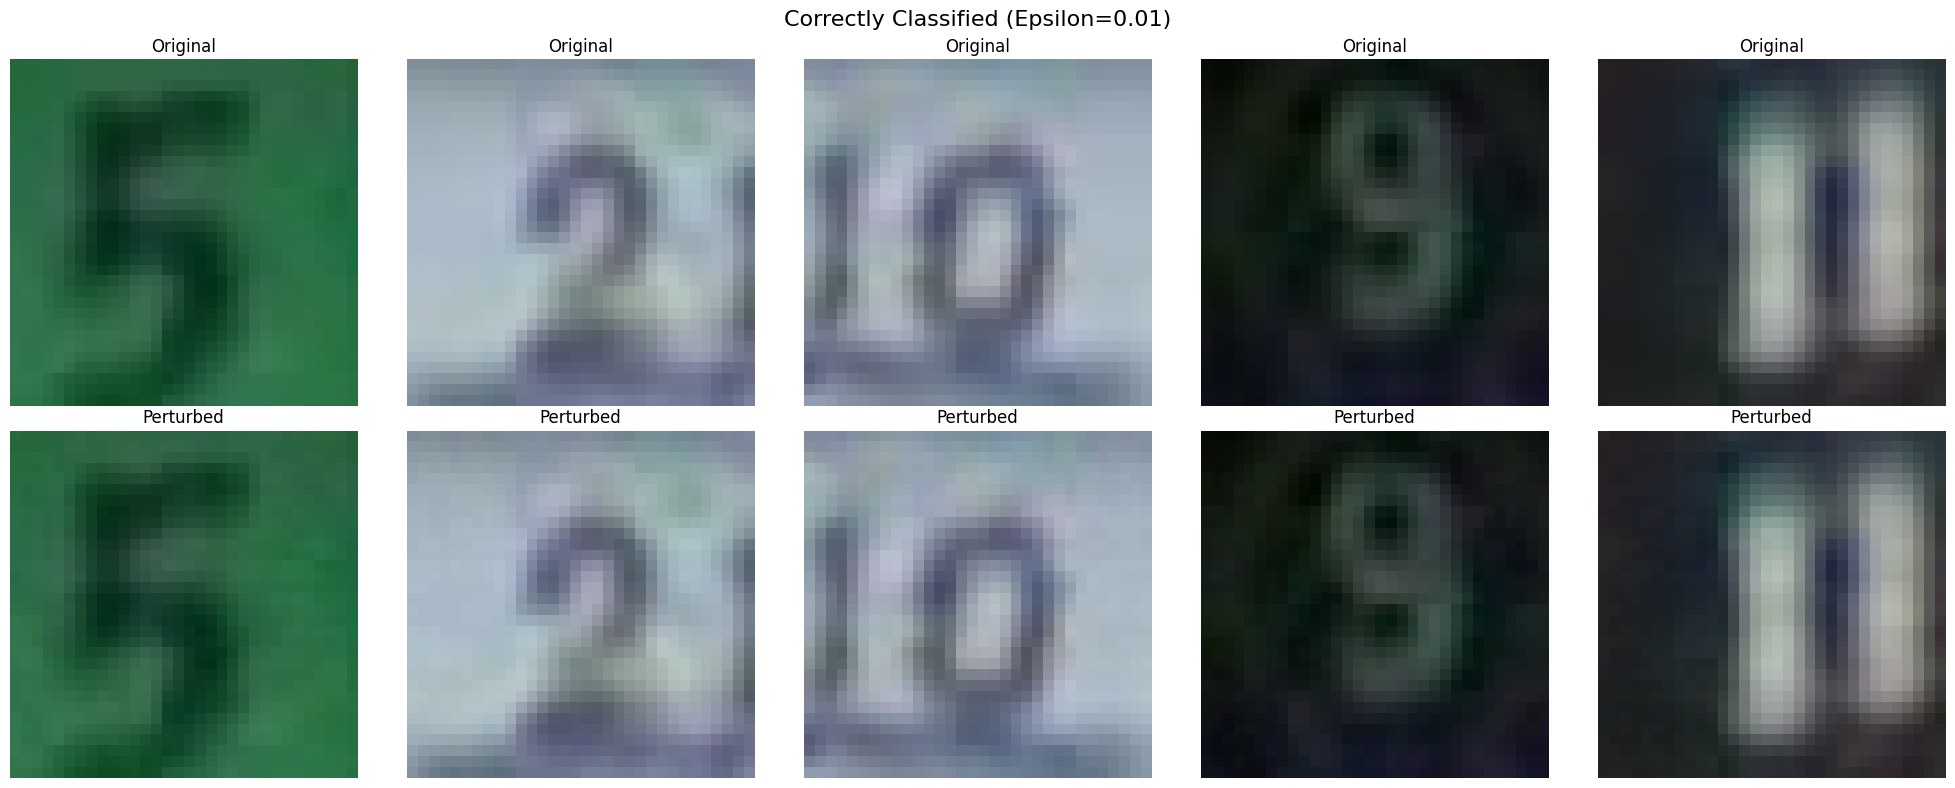

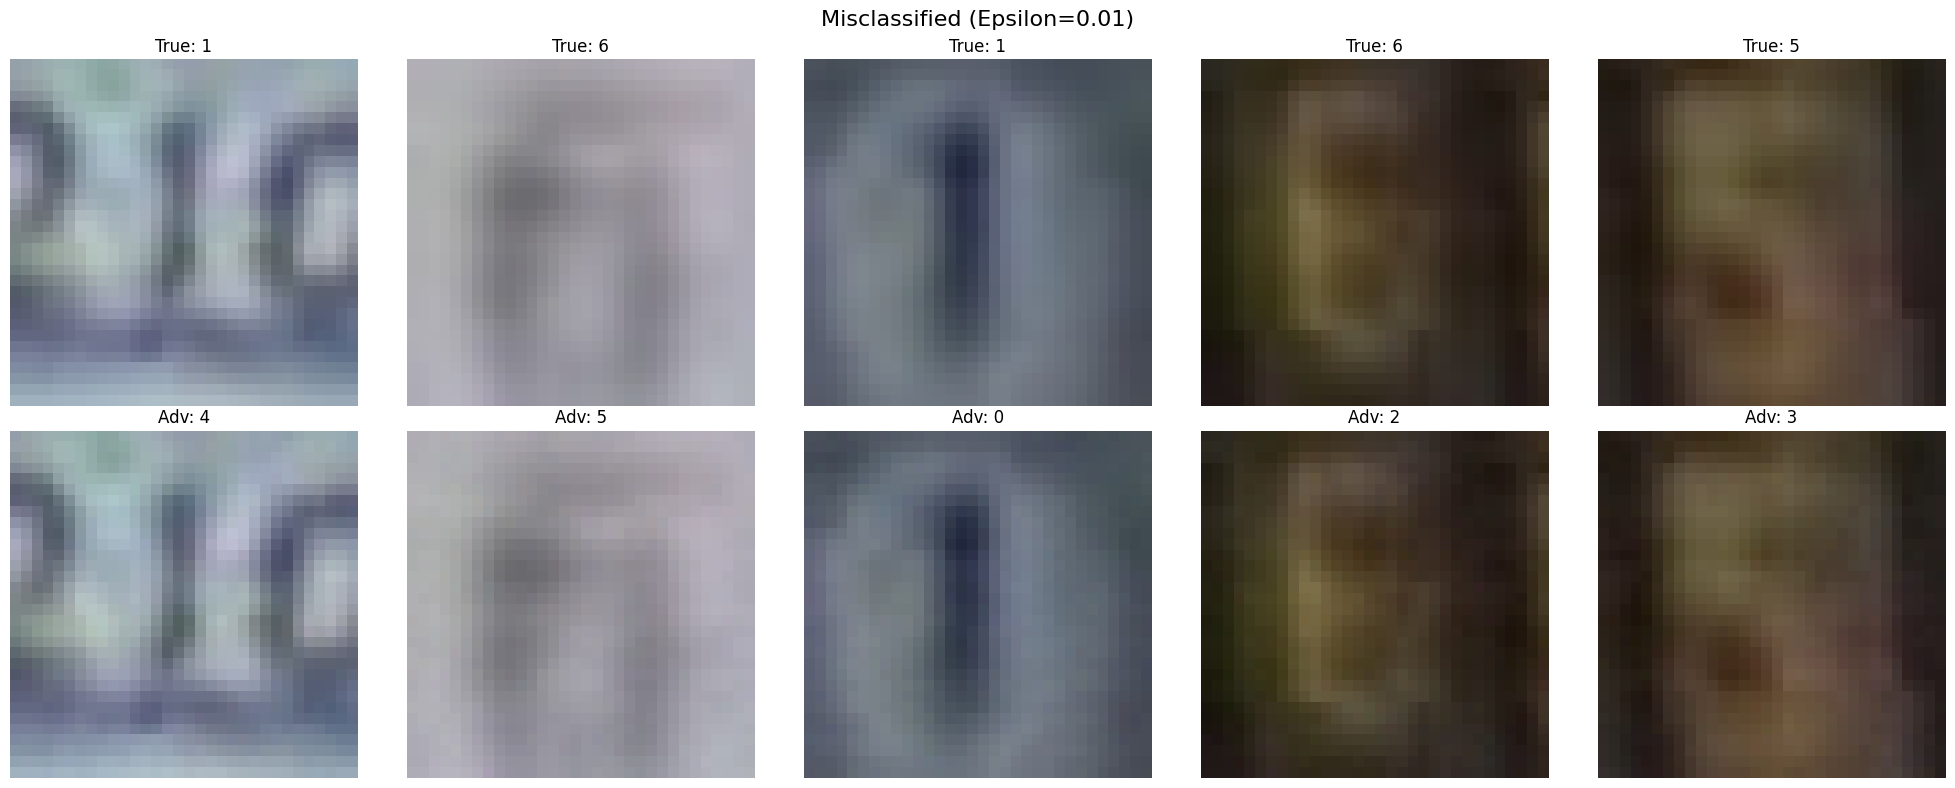

Accuracy after FGSM attack with epsilon=0.05: 35.07%


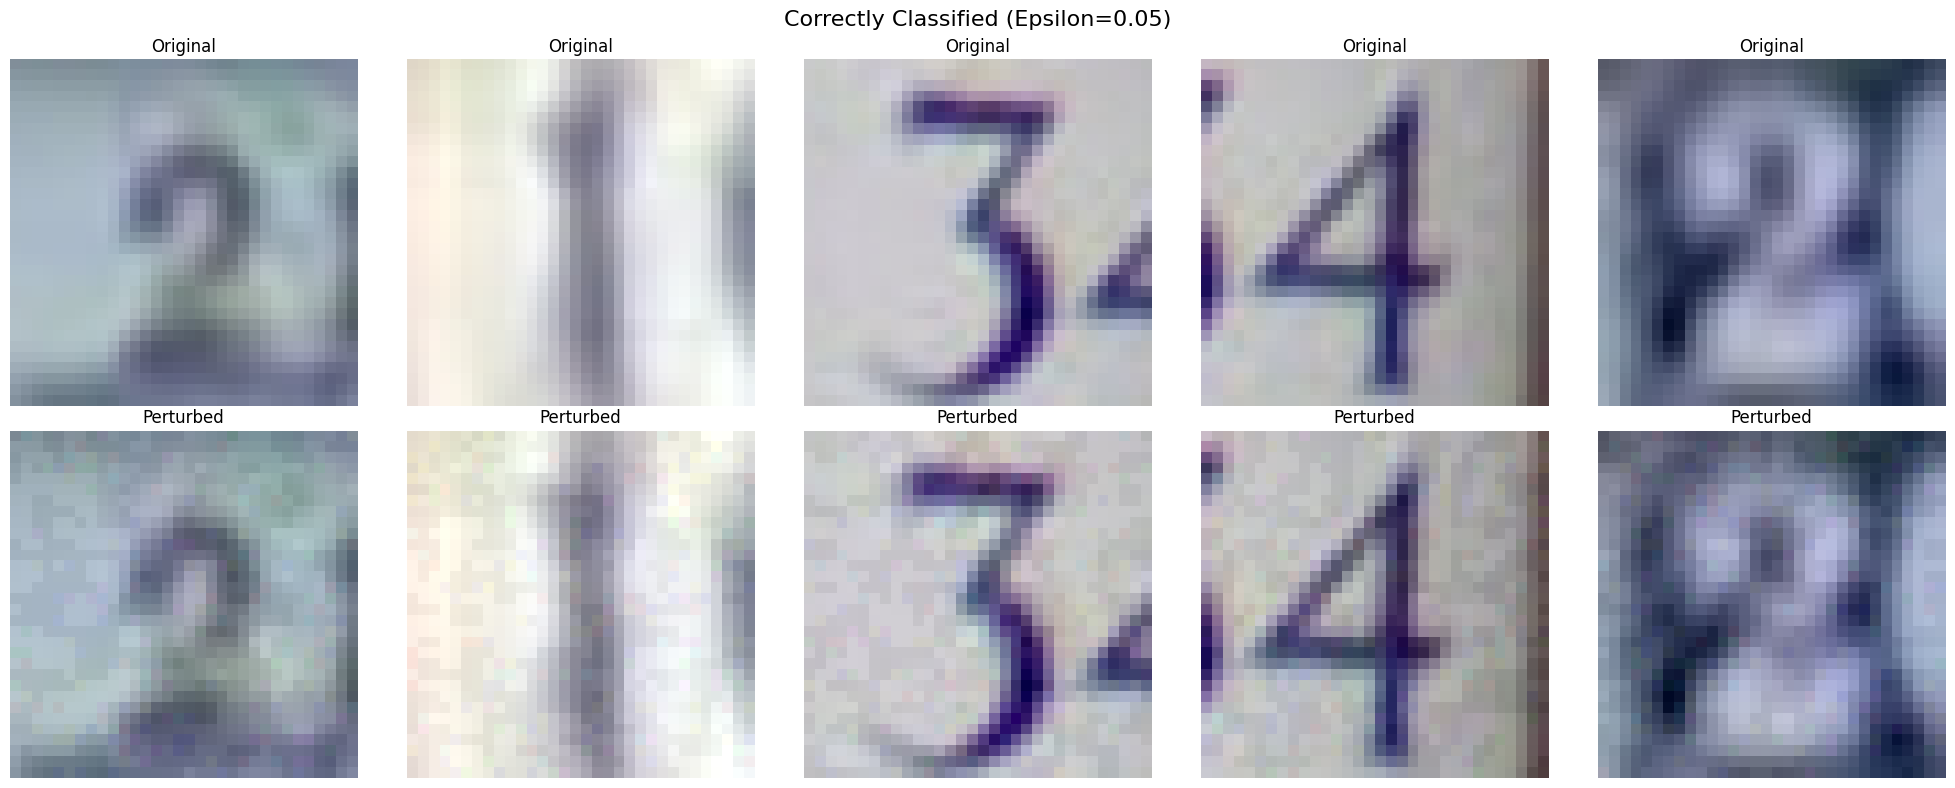

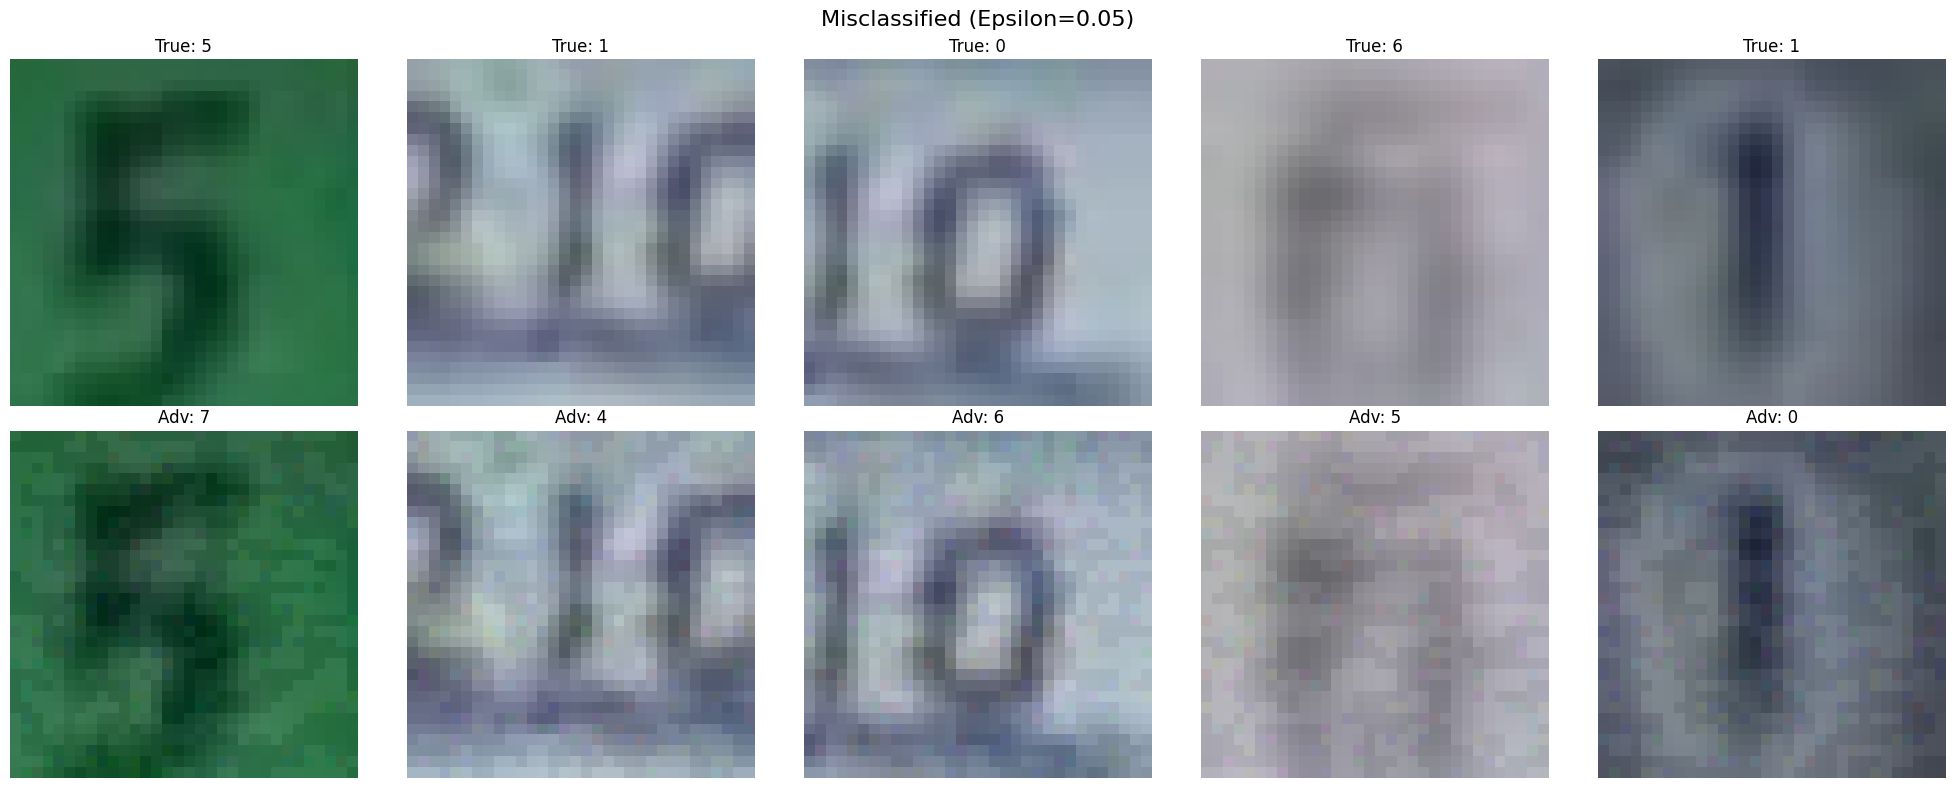

Accuracy after FGSM attack with epsilon=0.1: 15.30%


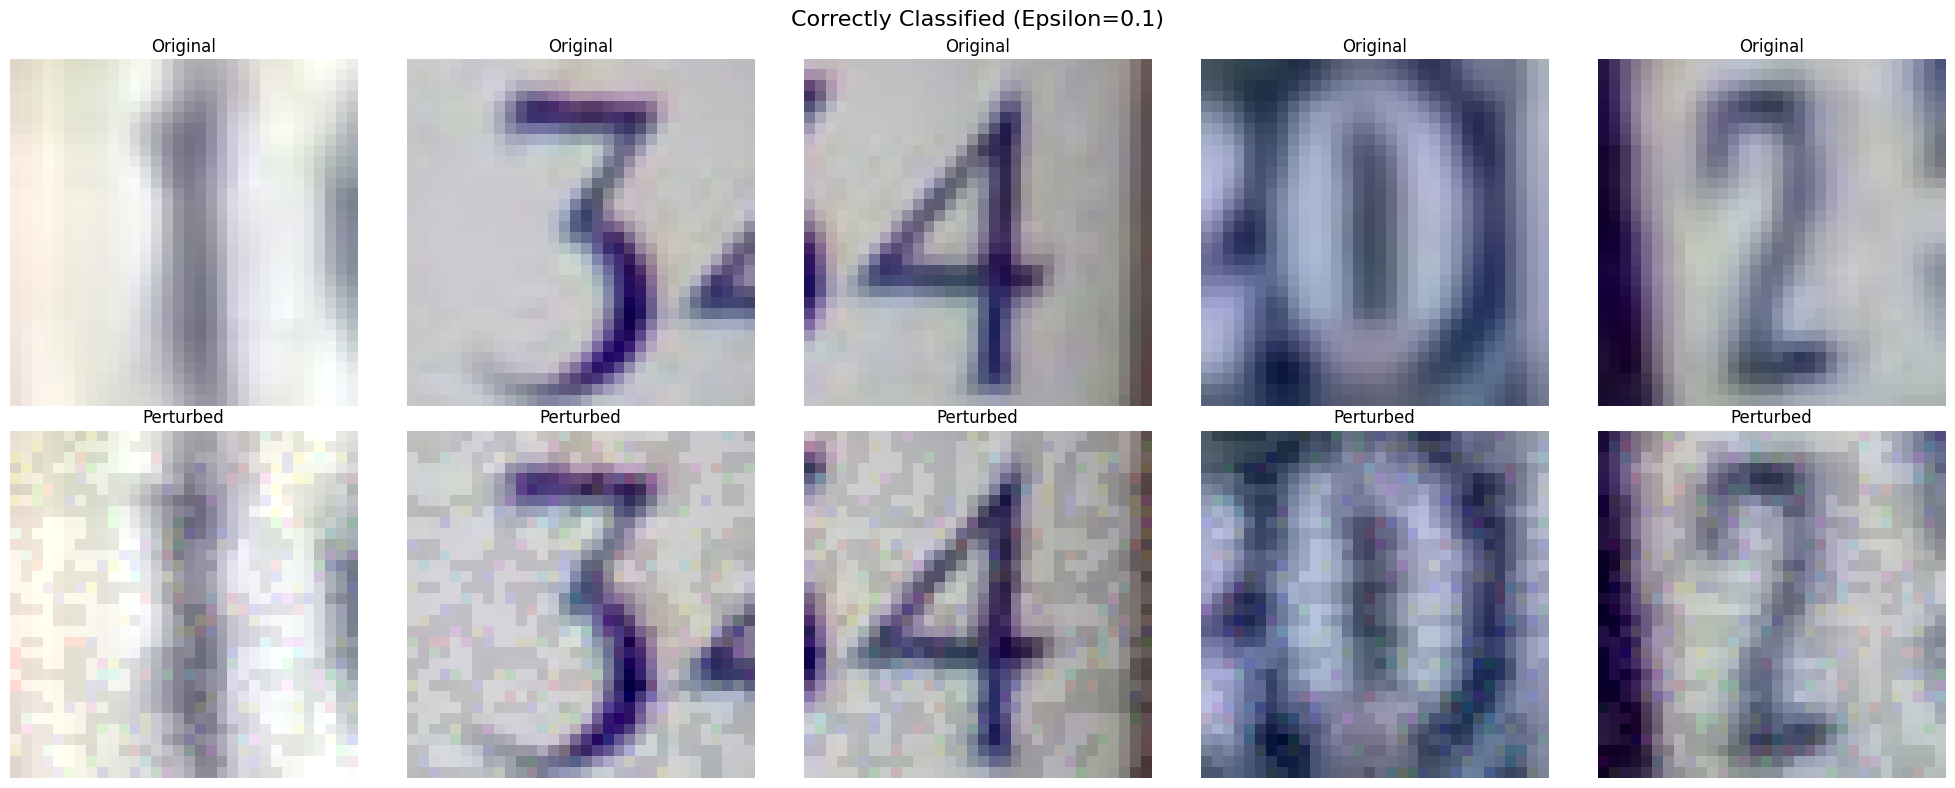

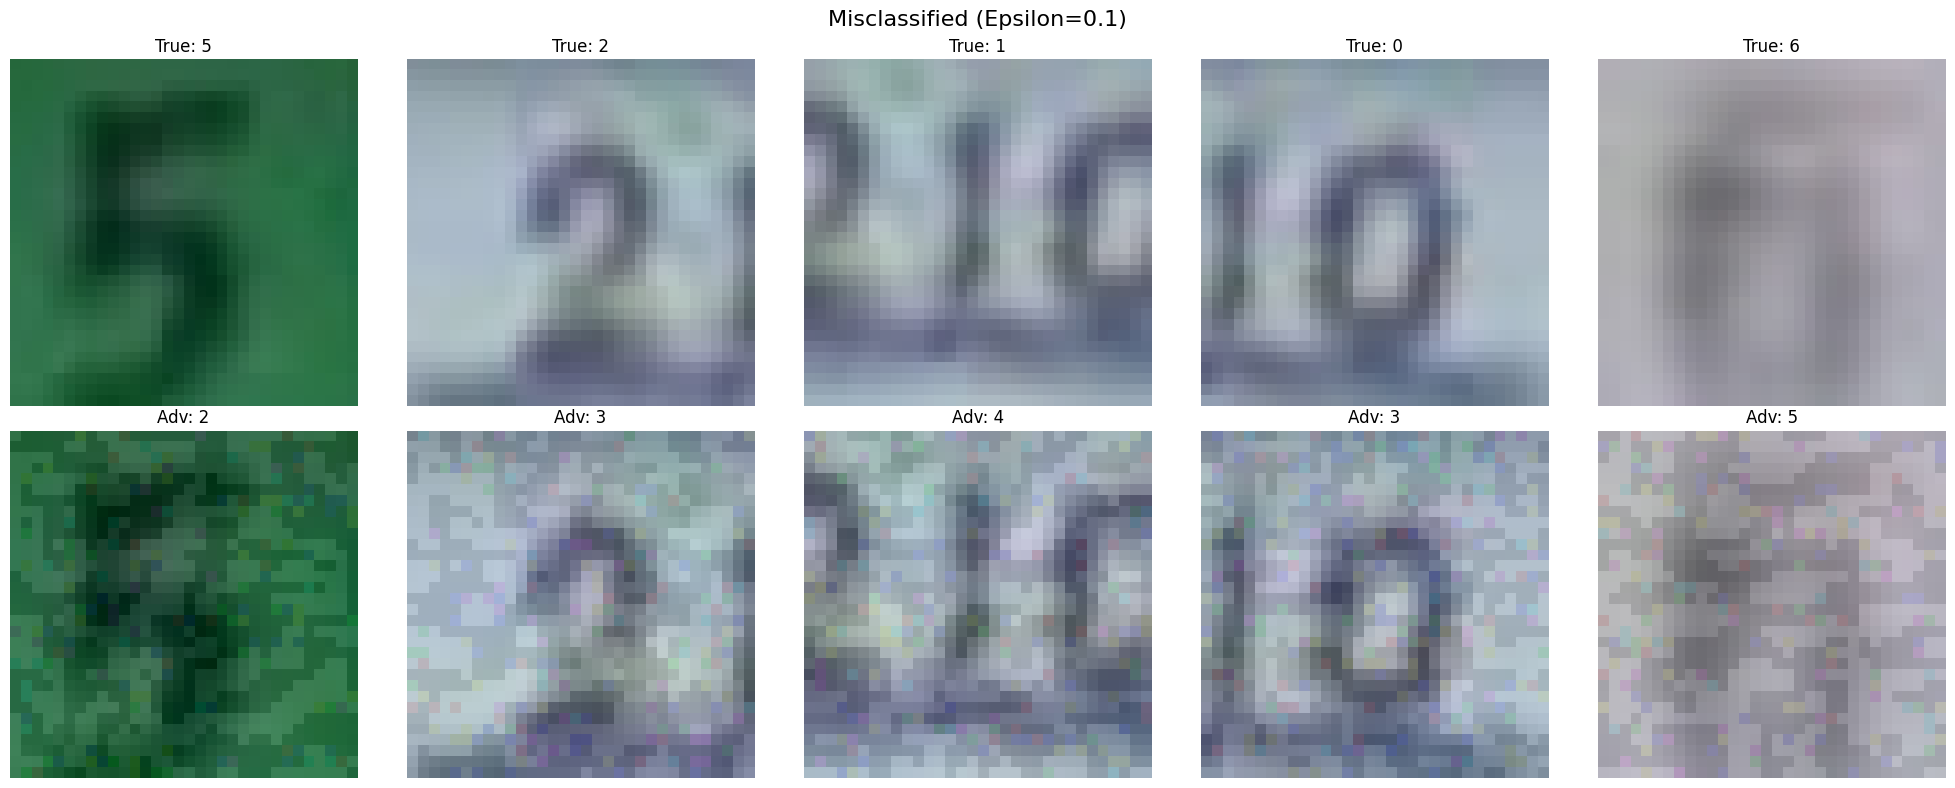

Accuracy after FGSM attack with epsilon=0.2: 6.01%


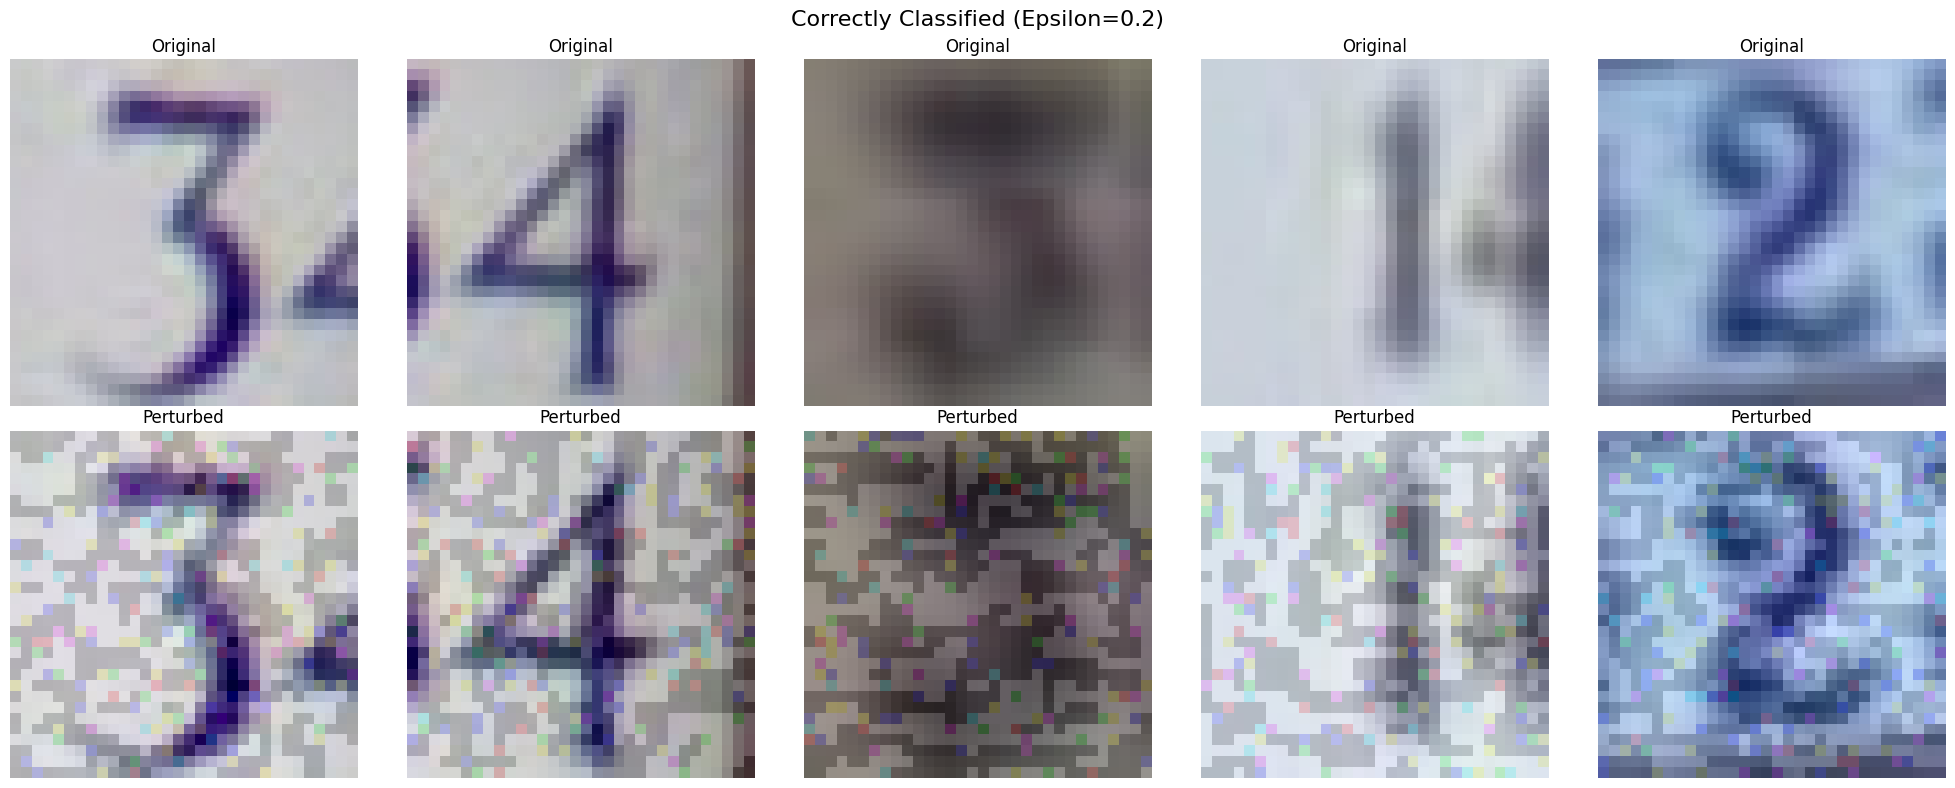

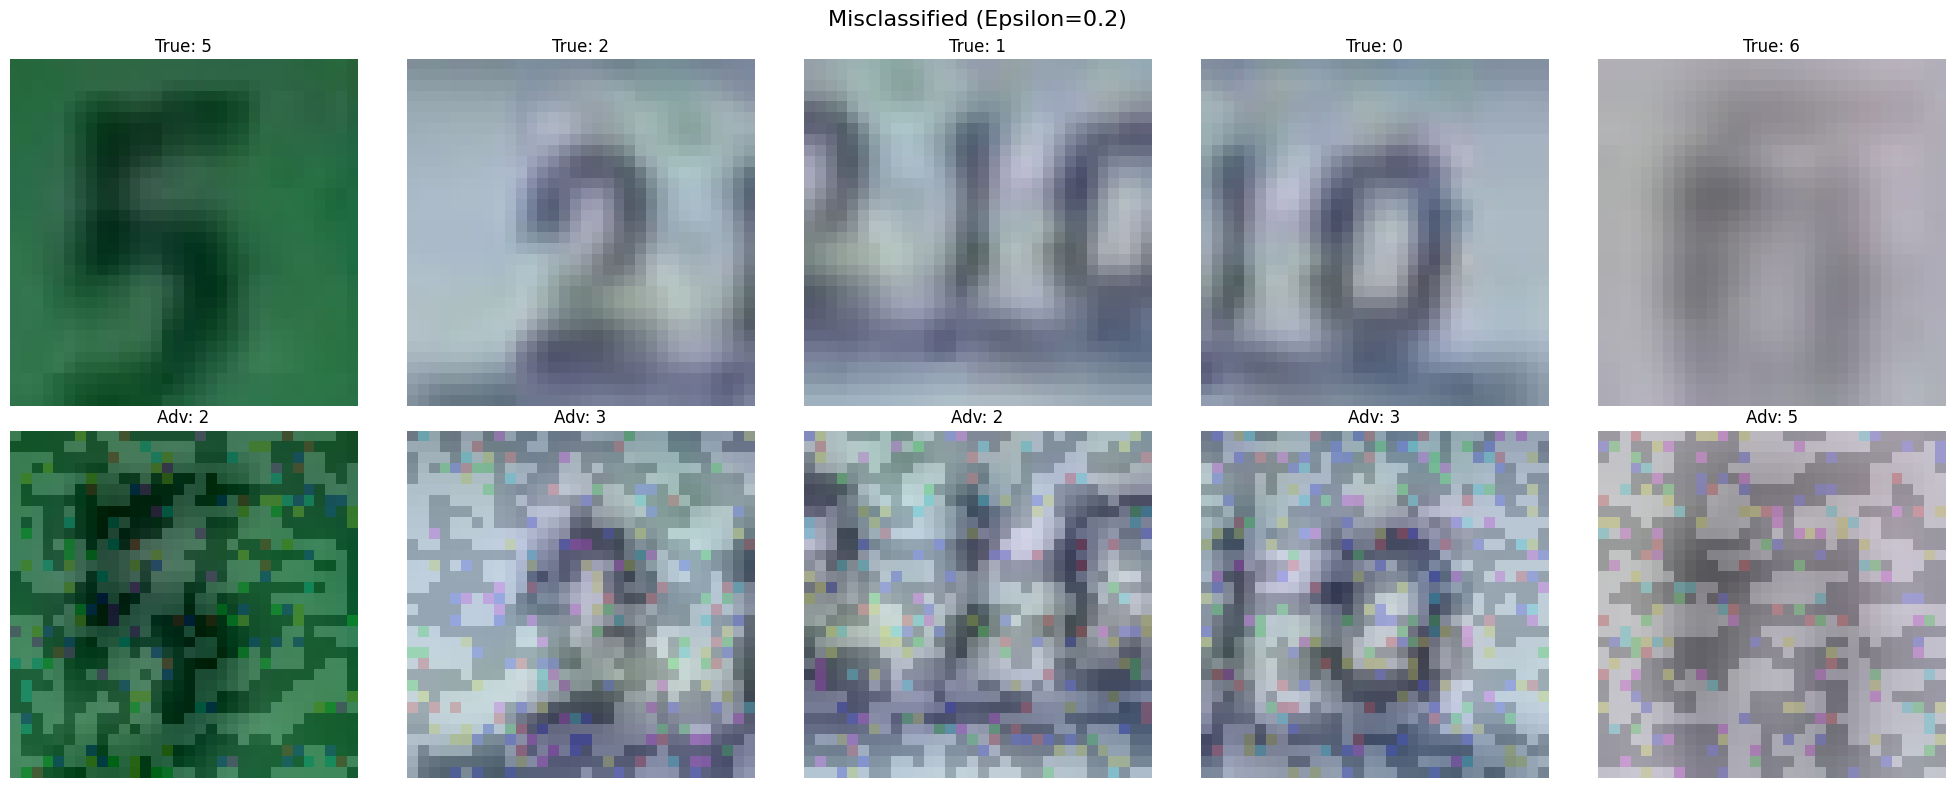

Accuracy after FGSM attack with epsilon=0.3: 5.34%


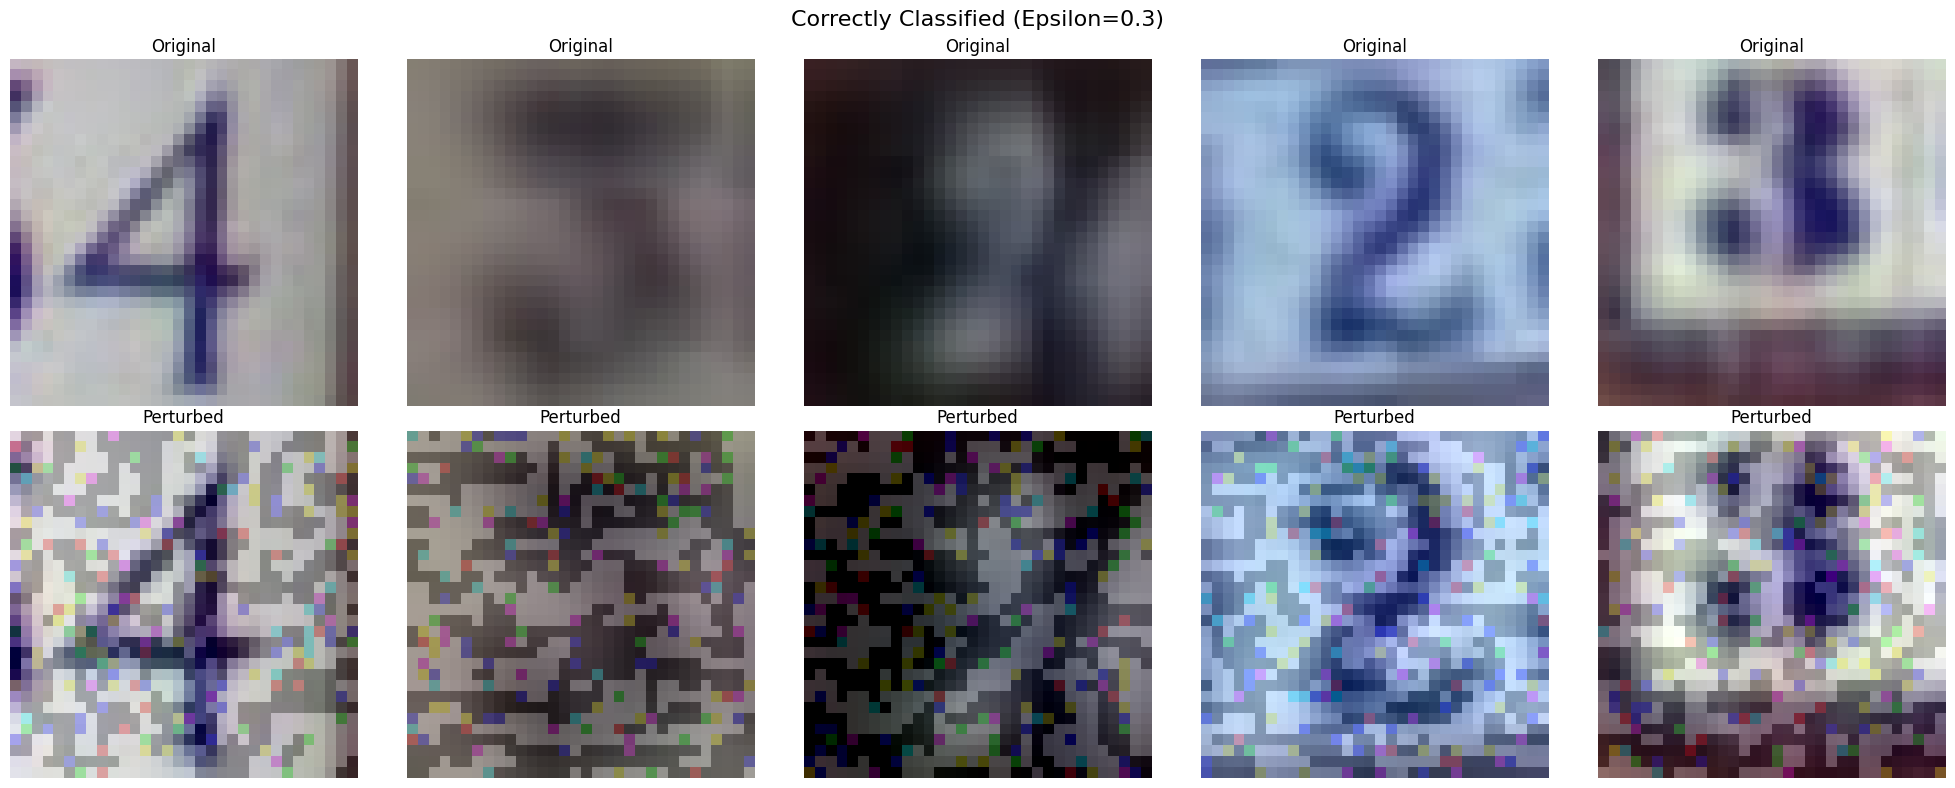

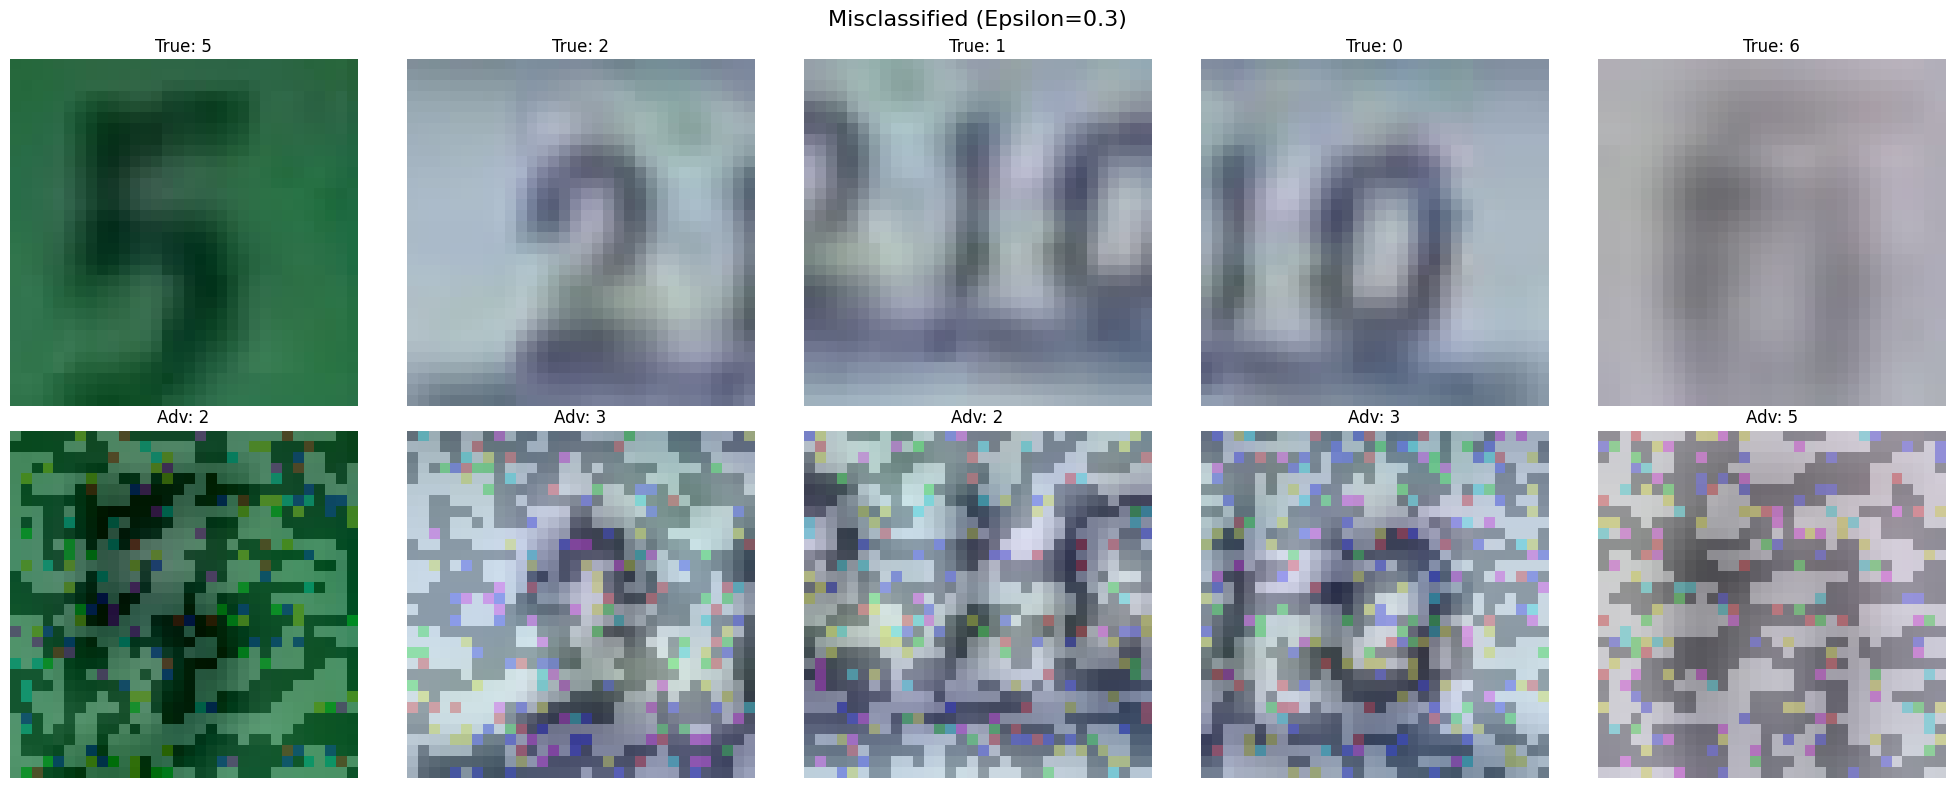

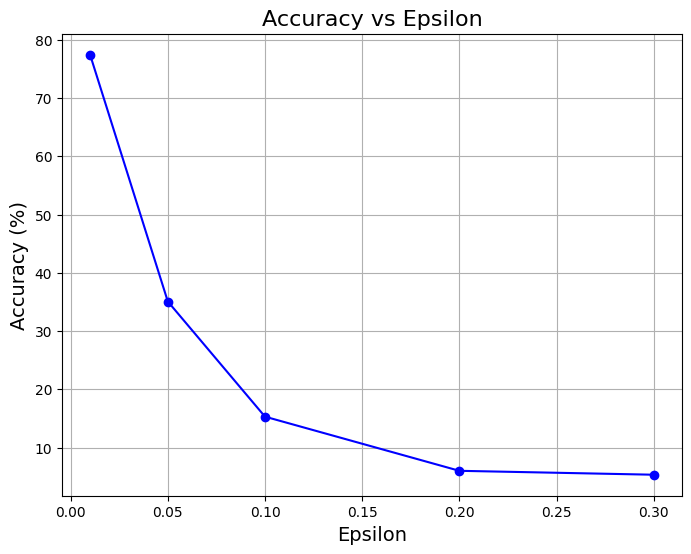

In [16]:
# Function to visualize both correctly classified and misclassified perturbed images
def visualize_perturbed_images(model, test_loader, epsilon):
    model.eval()
    correct_before = []
    correct_after = []
    incorrect_before = []
    incorrect_after = []
    true_labels = []
    predicted_labels = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        # Prediction before attack
        outputs = model(inputs)
        _, predicted_before = outputs.max(1)

        # Compute gradient
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Create adversarial images
        gradients = inputs.grad.data
        adversarial_inputs = fgsm_attack(inputs, epsilon, gradients)

        # Prediction after attack
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_after = outputs_adversarial.max(1)

        # Collect examples
        for i in range(len(labels)):
            if predicted_before[i] == labels[i]:  # Correct before attack
                if predicted_after[i] == labels[i]:  # Correct after attack
                    correct_before.append(inputs[i].cpu().detach().numpy())
                    correct_after.append(adversarial_inputs[i].cpu().detach().numpy())
                else:  # Misclassified after attack
                    incorrect_before.append(inputs[i].cpu().detach().numpy())
                    incorrect_after.append(adversarial_inputs[i].cpu().detach().numpy())
                    true_labels.append(labels[i].item())
                    predicted_labels.append(predicted_after[i].item())

            if len(correct_before) >= 5 and len(incorrect_before) >= 5:  # Stop after 5 examples each
                break
        if len(correct_before) >= 5 and len(incorrect_before) >= 5:
            break

    # Display correctly classified images
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f"Correctly Classified (Epsilon={epsilon})", fontsize=16)
    for i in range(5):
        # Original image
        img = correct_before[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Undo normalization
        axes[0, i].imshow(img)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Perturbed image
        perturbed_img = correct_after[i].transpose(1, 2, 0)
        perturbed_img = (perturbed_img * 0.5) + 0.5
        axes[1, i].imshow(perturbed_img)
        axes[1, i].set_title("Perturbed")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

    # Display misclassified images
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f"Misclassified (Epsilon={epsilon})", fontsize=16)
    for i in range(5):
        # Original image
        img = incorrect_before[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Undo normalization
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"True: {true_labels[i]}")
        axes[0, i].axis("off")

        # Perturbed image
        perturbed_img = incorrect_after[i].transpose(1, 2, 0)
        perturbed_img = (perturbed_img * 0.5) + 0.5
        axes[1, i].imshow(perturbed_img)
        axes[1, i].set_title(f"Adv: {predicted_labels[i]}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


# Test with different epsilon values
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]
accuracies = []

for epsilon in epsilon_values:
    accuracy = eval_adversarial(model, test_loader, epsilon)
    accuracies.append(accuracy)
    visualize_perturbed_images(model, test_loader, epsilon)

# Plot accuracy as a function of epsilon
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs Epsilon", fontsize=16)
plt.xlabel("Epsilon", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.grid(True)
plt.show()

The graph and images illustrate how the FGSM attack affects the model’s accuracy and the readability of adversarial examples as the ε (epsilon) value increases. There is a clear negative correlation between ε and accuracy – as the attack strength increases, the model’s ability to correctly classify digits decreases significantly.

At low ε values (0.01 - 0.05), the perturbations are nearly invisible to the human eye but are still effective in confusing the model. At moderate values (0.1 - 0.2), accuracy drops significantly, and the digits start to appear noisy, yet they remain recognizable to humans. When ε reaches 0.2 or higher, the images become highly distorted, the model struggles to classify correctly, and even humans may find it difficult to recognize the original digits.

The findings suggest that ε values between 0.05 and 0.1 represent a balance – strong enough to fool the model but still readable by humans, while values above 0.2 completely disrupt recognition. This analysis highlights the vulnerability of deep learning models to adversarial attacks and the necessity for defense strategies to enhance the model’s robustness against small perturbations in input data.

## Part 3: Training our model using adversarial training

For each point in the training data, increase the model's robustness by training not only on the point itself, but on the perturbed point after the FGSM algorithm using $\varepsilon=0.1$. Afterwards, compute the accuracy once again on the newly trained model using ```eval_adversarial(model, test_loader, epsilon)``` defined above. The accuracy (LOOKING ONLY AT THE PERTURBED DATA) should be at least 70%.

In [26]:
# פונקציה לאימון עם Adversarial Training
def train_adversarial_model(model, train_loader, val_loader, criterion, optimizer, device, epsilon, alpha, epochs=50, patience=5):
    """
    Train the model using both original and FGSM-perturbed data (Adversarial Training) with validation.
    """
    best_val_accuracy = 0.0
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True  # Enable gradient tracking
            
            # Forward pass on original data
            outputs_original = model(inputs)
            loss_original = criterion(outputs_original, labels)
            
            # Compute gradients and generate adversarial examples
            model.zero_grad()
            loss_original.backward(retain_graph=True)
            gradients = inputs.grad.data
            adversarial_inputs = fgsm_attack(inputs, epsilon, gradients)
            
            # Forward pass on adversarial data
            outputs_adversarial = model(adversarial_inputs)
            loss_adversarial = criterion(outputs_adversarial, labels)
            
            # Combined loss
            loss_combined = alpha * loss_original + (1 - alpha) * loss_adversarial
            
            # Backpropagation
            optimizer.zero_grad()
            loss_combined.backward()
            optimizer.step()
            
            running_loss += loss_combined.item()
            _, predicted = outputs_original.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100. * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100. * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    print("Adversarial training completed!")
    return model

# אימון המודל על סט האימון עם Adversarial Training
epsilon = 0.1  # Perturbation magnitude
alpha = 0.8    #  balance factor between original and adversarial loss
epochs = 50    #  number of training epochs
patience = 5    # Early stopping criteria
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)  # Reduced LR to improve generalization

# Train the model using adversarial training
model = train_adversarial_model(model, train_loader, val_loader, criterion, optimizer, device, epsilon, alpha, epochs, patience)

# טען את המודל הטוב ביותר להערכת הביצועים
model.load_state_dict(torch.load("best_model.pth"))

# # בדיקת הדיוק על הדאטה המותקף
# eval_adversarial(model, test_loader, epsilon)

# הערכת המודל לאחר Adversarial Training
accuracy = eval_adversarial(model, test_loader, epsilon)
print(f'Accuracy on perturbed data after adversarial training (epsilon={epsilon}): {accuracy:.2f}%')


Epoch 1/50, Loss: 0.4150, Train Accuracy: 88.58%
Validation Loss: 0.4561, Validation Accuracy: 86.51%
Epoch 2/50, Loss: 0.4108, Train Accuracy: 88.44%
Validation Loss: 0.4615, Validation Accuracy: 85.95%
Epoch 3/50, Loss: 0.4112, Train Accuracy: 88.70%
Validation Loss: 0.4995, Validation Accuracy: 84.90%
Epoch 4/50, Loss: 0.4077, Train Accuracy: 88.81%
Validation Loss: 0.4557, Validation Accuracy: 86.62%
Epoch 5/50, Loss: 0.4124, Train Accuracy: 88.75%
Validation Loss: 0.5078, Validation Accuracy: 85.07%
Epoch 6/50, Loss: 0.4107, Train Accuracy: 88.79%
Validation Loss: 0.5355, Validation Accuracy: 83.66%
Epoch 7/50, Loss: 0.4099, Train Accuracy: 88.94%
Validation Loss: 0.4464, Validation Accuracy: 87.19%
Epoch 8/50, Loss: 0.4039, Train Accuracy: 88.97%
Validation Loss: 0.4580, Validation Accuracy: 86.46%
Epoch 9/50, Loss: 0.4053, Train Accuracy: 89.00%
Validation Loss: 0.5093, Validation Accuracy: 84.63%
Epoch 10/50, Loss: 0.4070, Train Accuracy: 88.89%
Validation Loss: 0.4614, Validat

/tmp/ipykernel_18804/1715387330.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Accuracy after FGSM attack with epsilon=0.1: 76.34%
Accuracy on perturbed data after adversarial training (epsilon=0.1): 76.34%


In this code, we perform **adversarial training** by including both the original images and FGSM-perturbed images (with epsilon=0.1) in each training batch. We generate adversarial examples on the fly—after computing gradients on the original loss—and then combine the original loss (**loss_original**) with the adversarial loss (**loss_adversarial**) using a weighted approach controlled by **alpha=0.8**. This setup ensures the network sees challenging adversarial variants at every iteration, gradually making it more resistant to attacks.  

We train for up to **50 epochs** and rely on **early stopping** with a patience of **5 epochs** to prevent overfitting. If the validation accuracy does not improve within the patience window, training stops early. Additionally, we reduce the learning rate by using **Adam optimizer** with **weight decay (1e-4)** to improve generalization. The best-performing model (based on validation accuracy) is saved as `"best_model.pth"`.  

Throughout the process, we monitor validation accuracy at each epoch, resetting a patience counter only when the model’s validation accuracy improves. If the accuracy fails to improve beyond a certain number of epochs (the patience threshold), early stopping is triggered. After training, we reload the best model and evaluate its performance on adversarially perturbed test data using `eval_adversarial(model, test_loader, epsilon)`.  

Ultimately, this adversarial training procedure raises the model’s accuracy on perturbed data **significantly**, demonstrating the impact of adversarial training in making the model more robust against FGSM attacks.

### Visualization

Display the confusion matrix along with some examples of images that the model classified incorrectly. Discuss the performance of the model now compared to before.

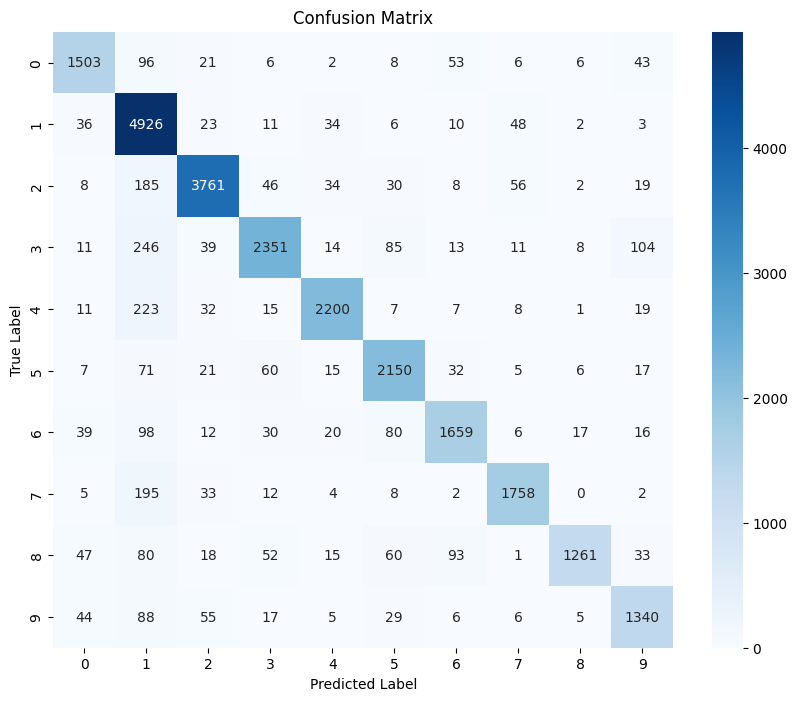

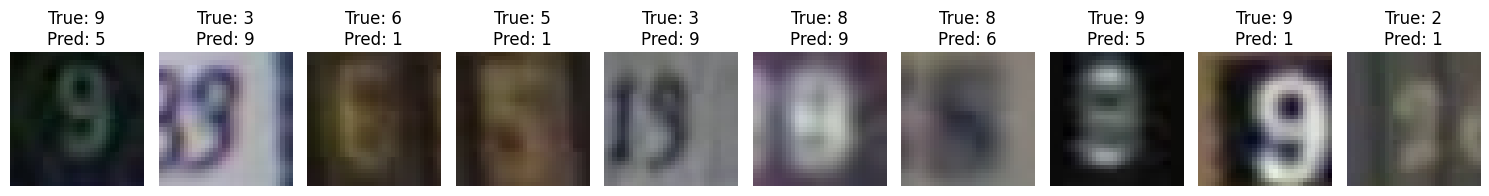

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# פונקציה להערכת המודל ויצירת תחזיות
def analyze_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # שמירת תמונות שגויות
            for i in range(len(labels)):
                if labels[i] != predicted[i]:
                    incorrect_images.append(inputs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_predictions.append(predicted[i].cpu().item())

    return all_labels, all_predictions, incorrect_images, incorrect_labels, incorrect_predictions

# קבלת תוצאות המודל
all_labels, all_predictions, incorrect_images, incorrect_labels, incorrect_predictions = analyze_model(model, test_loader, device)

# יצירת מטריצת בלבול
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# הצגת תמונות שגויות
def display_incorrect_images(images, true_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].transpose(1, 2, 0)  # תצוגת RGB
        img = (img * 0.5) + 0.5  # הסרת הנרמול
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# הצגת 10 תמונות שגויות לדוגמה
display_incorrect_images(incorrect_images, incorrect_labels, incorrect_predictions, num_images=10)


The **confusion matrix** illustrates the classification accuracy by displaying correct and incorrect predictions for each digit, where darker shades represent higher counts. The model performs well on certain digits, such as "1" with **4926** correct classifications, but struggles with others, particularly **3 misclassified as 9 and 9 misclassified as 5**, which indicates issues with visually similar digits. Off-diagonal elements highlight these misclassifications, emphasizing that digits with similar shapes tend to be confused. The second visualization presents **ten misclassified images**, displaying the true label and the model’s incorrect prediction. Many of these errors arise from **blurry, distorted, or poorly illuminated images**, making classification difficult. Some digits, like **9 mistaken for 5 or 3 mistaken for 9**, resemble each other in shape, leading to frequent confusion. While adversarial training with **FGSM perturbations (ε = 0.1)** improved robustness, raising accuracy on adversarial samples to **76.34%**, it did not eliminate all misclassifications, especially those caused by natural variations in digit appearance. The model still struggles with inherent distortions and ambiguous cases, suggesting that additional improvements, such as **more data augmentation** (e.g., rotations, contrast adjustments) or **higher epsilon values for stronger adversarial training**, could enhance its robustness further. Despite these errors, adversarial training successfully increased resilience to small perturbations, but further refinements in architecture and preprocessing techniques are necessary to minimize natural misclassifications.

## Part 4: Contrastive Learning

In this section, we will work on creating informative embeddings for images using SimCLR. For this section we will use the attached subset of the popular ImageNet dataset of 96x96 images from 1000 classes. Below, we provide you with several functions to implement a contrastive learning model.

### Dry Questions

Before implementation, take these questions in consideration (and provide your answers and explanations):

1. When training an unsupervised contrastive learning model such as SimCLR, would we prefer to have a large or small batch size?
2. In general, what possible evaluation metrics could be used in this task (unsupervised representation learning) to measure our model's performance?
3. When creating embeddings for images in the test set, how does the process differ from what we do in training?
4. For each of the following image augmentations, explain whether or not we would like to use them in the SimCLR framework:
    - Randomly cropping a fixed-size window in the image.
    - Enlarging the image to 128x128.
    - Random rotation of the image.
    - Adding Gaussian noise.
    - Randomly changing the image's dimensions.
    - Randomly converting the image to grayscale.

### ANSWERS

### 1. 
When training an unsupervised contrastive learning model such as SimCLR, we prefer to use a large batch size. This is because the NT-Xent Loss relies on both positive and negative pairs, and a larger batch size provides a more diverse set of negative pairs (unrelated examples) for each positive pair. This diversity helps the model learn more meaningful embeddings by effectively distinguishing between similar and dissimilar samples, ultimately improving generalization. Empirical evidence from the SimCLR paper shows that larger batch sizes significantly enhance the quality of the learned embeddings. However, large batch sizes require substantial computational resources, so techniques like memory banks or multi-GPU training are often used as practical solutions to overcome these limitations.

### 2.
In the context of unsupervised representation learning for our task, the most relevant evaluation methods are:

Linear Evaluation Protocol: A linear classifier is trained on top of the embeddings using a labeled subset of the data. The classifier's performance, measured through metrics like accuracy or F1-score, reflects the quality of the representations.

k-Nearest Neighbors (k-NN) Accuracy: This evaluates the embeddings by classifying samples based on their nearest neighbors in the embedding space, providing an intuitive measure of how well similar samples are grouped.

Clustering Metrics: Metrics like Normalized Mutual Information (NMI) or Adjusted Rand Index (ARI) assess how well the learned embeddings capture the underlying structure of the data by comparing clustering results to ground truth labels.

Visualization: Techniques such as t-SNE or UMAP allow for a visual inspection of the embedding space, helping determine if similar samples form distinct clusters.

These methods are particularly suited for evaluating unsupervised representation learning models, as they emphasize the quality and structure of the learned embeddings.

### 3.
 When creating embeddings for images in the test set, the process differs from training in the following key ways:
No Data Augmentation:
During training, data augmentations (e.g., cropping, flipping, color jittering) are applied to create multiple augmented views of the same image to help the model learn robust representations.
In the test phase, no augmentations are applied to ensure the embeddings represent the original image.

No Contrastive Loss:
In training, the embeddings are used to compute the contrastive loss (e.g., NT-Xent Loss) by comparing positive and negative pairs.
In the test phase, we directly extract the embeddings without computing any loss.

Frozen Model Parameters:
During training, the model parameters are updated using backpropagation.
In the test phase, the model operates in evaluation mode (model.eval()), and the parameters remain frozen, ensuring that batch normalization statistics and dropout are handled appropriately.

Single View per Image:
In training, multiple augmented views of each image are used to compute positive pairs.
In the test phase, each image is passed through the encoder only once to obtain its embedding.

Focus on Downstream Tasks:
In training, the goal is to learn embeddings that separate similar and dissimilar pairs.
In the test phase, the embeddings are typically used for downstream tasks such as classification, clustering, or retrieval.

### 4.
1. Randomly cropping a fixed-size window in the image
Use in SimCLR? Yes.
Reason: Random cropping creates spatial variations of the image, which forces the model to focus on shared semantic features rather than precise locations of objects. This is one of the most effective augmentations used in SimCLR for generating positive pairs.
2. Enlarging the image to 128x128
Use in SimCLR? No.
Reason: Enlarging the image introduces scale inconsistencies and interpolation artifacts, which can negatively affect the training process. Maintaining a consistent input size is critical for ensuring meaningful embeddings.
3. Random rotation of the image
Use in SimCLR? Yes (with limitations).
Reason: Small random rotations help the model learn rotational invariance, which can improve robustness. However, large rotations may distort the semantic meaning of certain images (e.g., a rotated house number might no longer resemble its original class).
4. Adding Gaussian noise
Use in SimCLR? Yes.
Reason: Adding Gaussian noise introduces subtle variations in pixel values, which helps the model learn to focus on higher-level semantic features instead of noise-sensitive low-level features. However, the magnitude of noise should be carefully controlled to avoid overly distorting the image.
5. Randomly changing the image's dimensions
Use in SimCLR? No.
Reason: Randomly altering dimensions (e.g., stretching or shrinking non-proportionally) distorts the aspect ratio of the image, which can introduce unnatural artifacts and reduce the model's ability to learn meaningful representations.
6. Randomly converting the image to grayscale
Use in SimCLR? Yes.
Reason: Grayscale conversion removes color information, encouraging the model to focus on texture, structure, and other semantic features. This is particularly useful in datasets where color is not a critical feature.


### Code

Do the following:

1. Create a CNN that makes embeddings for images (you can use pretrained foundation models if you'd like).
2. Implement any unsupervised contrastive loss (such as nt-xent in SimCLR).
3. Train the model (achieve loss less than 3.0).

Using the function ```plot_embeddings```, show the model's performance on the test data.

🔄 Loading datasets...
✅ Datasets loaded successfully!


/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🚀 Starting Training 🚀


/tmp/ipykernel_48058/3394745848.py:167: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
/tmp/ipykernel_48058/3394745848.py:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


🎯 Epoch [1/10], Loss: 3.5943
🎯 Epoch [2/10], Loss: 1.7104
🎯 Epoch [3/10], Loss: 1.2473
🎯 Epoch [4/10], Loss: 1.0354
🎯 Epoch [5/10], Loss: 0.8851
🎯 Epoch [6/10], Loss: 0.7814
🎯 Epoch [7/10], Loss: 0.7050
🎯 Epoch [8/10], Loss: 0.6410
🎯 Epoch [9/10], Loss: 0.5922
🎯 Epoch [10/10], Loss: 0.5552
💾 Model saved successfully!


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


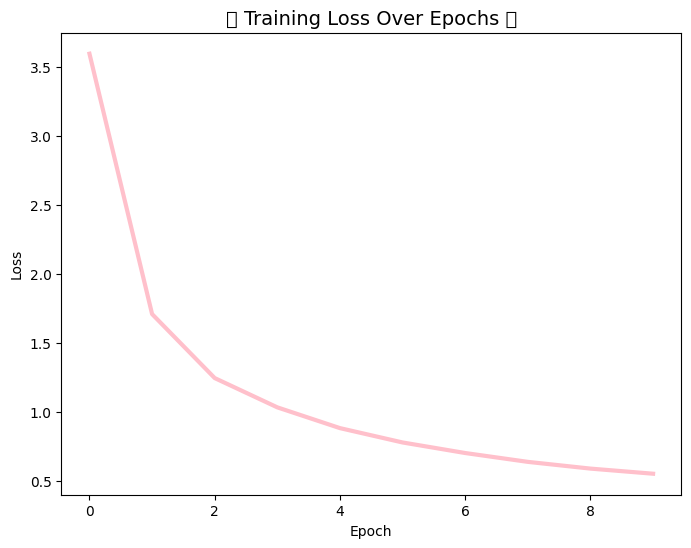

🖼️ Visualizing embeddings on test data...


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


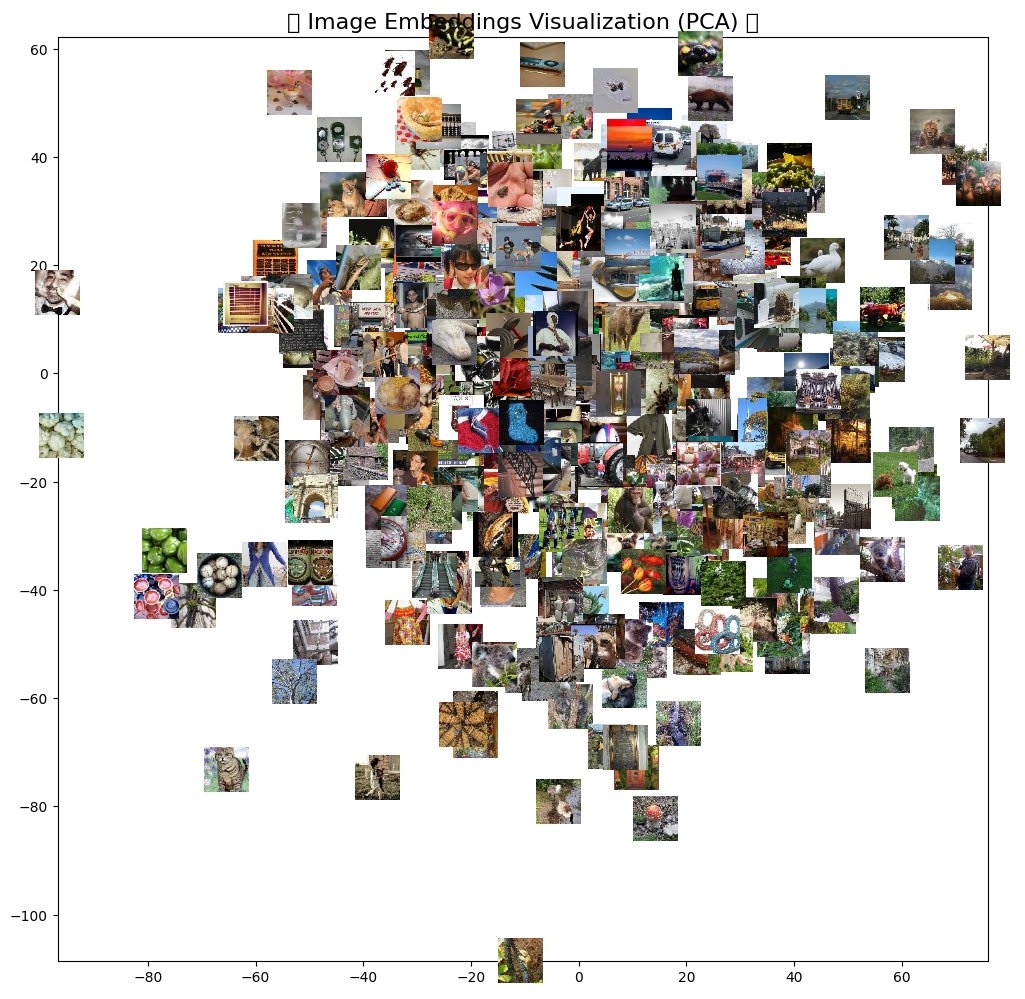

✅ Embeddings visualized!


In [10]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA  # For dimensionality reduction

# Constants
TRAIN_DIR = '/home/student/tiny_imagenet200/tiny-imagenet-200/tiny-imagenet-200/train/'
TEST_DIR = '/home/student/tiny_imagenet200/tiny-imagenet-200/tiny-imagenet-200/test/'
BATCH = 64
LEARNING_RATE = 5e-4

# Custom Dataset for Training
class ImageDatasetTrain(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.image_paths = []
        for label in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, label, 'images')):
                for img in os.listdir(os.path.join(root_dir, label, 'images')):
                    self.image_paths.append(os.path.join(root_dir, label, 'images', img))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        else:
            img1, img2 = img, img
        return img1, img2

# Custom Dataset for Testing
class ImageDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.image_paths = []
        for label in os.listdir(root_dir):
            for img in os.listdir(os.path.join(root_dir, label)):
                self.image_paths.append(os.path.join(root_dir, label, img))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img_transform = self.transform(img)
        return transforms.ToTensor()(img), img_transform

# Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=96, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
print("🔄 Loading datasets...")
train_dataset = ImageDatasetTrain(TRAIN_DIR, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, drop_last=True, num_workers=8)

test_dataset = ImageDatasetTest(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH, num_workers=8)
print("✅ Datasets loaded successfully!")

# Embedding Network
class EmbeddingModel(nn.Module):
    def __init__(self, pretrained=False):
        super(EmbeddingModel, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, 128)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# NT-Xent Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temp=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temp = temp
        self.eps = 1e-8

    def forward(self, emb1, emb2):
        emb1 = nn.functional.normalize(emb1, dim=1)
        emb2 = nn.functional.normalize(emb2, dim=1)
        emb = torch.cat([emb1, emb2], dim=0)

        sim_matrix = torch.exp(torch.mm(emb, emb.T) / self.temp)
        mask = (torch.ones_like(sim_matrix) - torch.eye(2 * BATCH, device=sim_matrix.device)).bool()
        sim_matrix = sim_matrix.masked_select(mask).view(2 * BATCH, -1)

        pos_sim = torch.exp(torch.sum(emb1 * emb2, dim=1) / self.temp)
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

        loss = -torch.log(pos_sim / (sim_matrix.sum(dim=1) + self.eps)).mean()
        return loss

# Plot Embeddings with PCA
def plot_embeddings(model, loader, device, num_samples=512):
    model.eval()
    embeddings = []
    images = []

    with torch.no_grad():
        for img_orig, img_t in loader:
            img_t = img_t.to(device)
            emb = model(img_t)
            embeddings.append(emb.cpu().numpy())
            images.extend(img_orig)
            if len(embeddings) * BATCH >= num_samples:
                break

    embeddings = np.concatenate(embeddings, axis=0)[:num_samples]
    images = images[:num_samples]

    # Use PCA to reduce embeddings to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Plot embeddings with images
    fig, ax = plt.subplots(figsize=(12, 12))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, embeddings_2d[i], frameon=False)
        ax.add_artist(ab)

    ax.set_xlim(embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max())
    ax.set_ylim(embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max())
    plt.title("🌟 Image Embeddings Visualization (PCA) 🌟", fontsize=16)
    plt.show()

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingModel().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
epochs = 10
loss_history = []

print("🚀 Starting Training 🚀")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (img1, img2) in enumerate(train_loader):
        img1, img2 = img1.to(device), img2.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            emb1 = model(img1)
            emb2 = model(img2)
            loss = criterion(emb1, emb2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"🎯 Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "embedding_model.pth")
print("💾 Model saved successfully!")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(loss_history, color='pink', linewidth=3)
plt.title("📉 Training Loss Over Epochs 📉", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Visualize Embeddings on Test Data
print("🖼️ Visualizing embeddings on test data...")
plot_embeddings(model, test_loader, device)
print("✅ Embeddings visualized!")

In this solution, we created a CNN for generating image embeddings by adapting a ResNet50 backbone and replacing its classification layer with a 128-dimensional output. This architecture serves as our embedding model, which transforms each image into a compact feature vector rather than producing a class prediction. We then implement an **unsupervised contrastive loss** (NT-Xent) that compares pairs of augmented images: each pair contains two random augmentations of the same base image (random cropping, flipping, color jitter, etc.). The loss function encourages the network to produce similar embeddings for augmented views of the same image while separating embeddings for different images, thus learning meaningful representations from unlabeled data.

During training, we monitor the contrastive loss, which starts around 3.59 and steadily drops below 3.0 by the third epoch (and eventually down to around 0.55), confirming that we have met the requirement of reducing the loss below 3.0. Finally, we use the **plot_embeddings** function on the test set to visualize these learned representations via a PCA projection into two dimensions. The resulting scatter plot shows images that share similar features clustering together, illustrating that our CNN-based embedding approach has captured robust, semantically rich features without reliance on explicit labels.

For some batch of the test loader, take 3 images in the batch. For each image, find and display the 5 images that have the closest embeddings to them. Do the chosen images make sense? If not, what could have possibly gone wrong with your model?

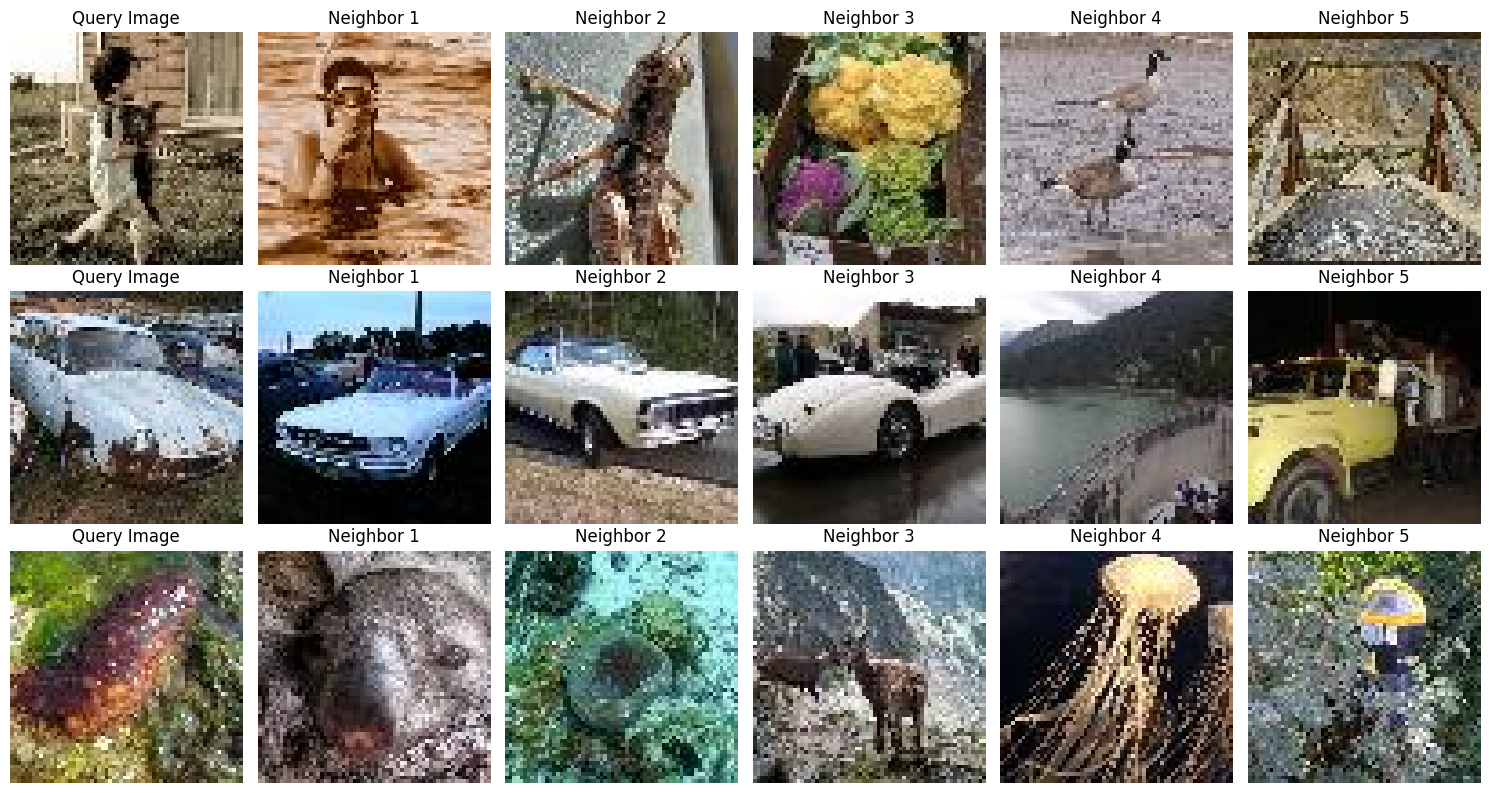

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to get embeddings from the model
def get_embeddings(loader):
    embeddings = []
    images = []
    with torch.no_grad():
        for img, _ in loader:
            img = img.to(device)
            emb = model(img).detach().cpu().numpy()
            embeddings.append(emb)
            images.append(img.cpu())
    embeddings = np.concatenate(embeddings, axis=0)
    images = torch.cat(images, dim=0)
    return embeddings, images

# Load all embeddings and images from the test set
test_embeddings, test_images = get_embeddings(test_loader)

# Function to find nearest neighbors
def find_nearest(query_embedding, all_embeddings, all_images, num_neighbors=5):
    distances = np.linalg.norm(all_embeddings - query_embedding, axis=1)
    indices = np.argsort(distances)[1:num_neighbors+1]  # skip the first one because it's the query image itself
    return all_images[indices]

# Select a batch and choose 3 images randomly to find their nearest neighbors
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images[:3]  # Select first 3 images for simplicity

# Display results
fig, axes = plt.subplots(3, 6, figsize=(15, 8))  # 3 rows for queries, 6 cols for query + 5 neighbors
for i, image in enumerate(images):
    query_embedding = model(image.unsqueeze(0).to(device)).detach().cpu().numpy()
    nearest_images = find_nearest(query_embedding, test_embeddings, test_images)
    axes[i, 0].imshow(image.permute(1, 2, 0))
    axes[i, 0].set_title("Query Image")
    axes[i, 0].axis('off')
    
    for j, neighbor in enumerate(nearest_images):
        axes[i, j+1].imshow(neighbor.permute(1, 2, 0))
        axes[i, j+1].set_title(f"Neighbor {j+1}")
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()


In this step, we take a small batch of images from the test set, compute each image’s embedding via our trained model, and then retrieve the 5 closest embeddings (nearest neighbors) from the entire test set (based on Euclidean distance in the embedding space). We display these neighbors alongside the original “query” image to see whether the model groups together semantically similar samples. If the neighbors for a given query image appear conceptually related (e.g., similar objects or scenes), it suggests the model has learned robust features that correctly capture visual or semantic similarity. If, however, the chosen neighbors look random or share only superficial traits (such as color or background patterns), it may indicate the model’s representations are not well aligned with meaningful concepts.

Lets take a look to our outputs:
In the first row, the query image shows a child holding a pet, but the nearest neighbors include a diver, an insect, some ornamental plants, and a pair of geese—none of which share a strong semantic connection to the child or the pet. This mismatch suggests our embedding may be relying more on overall hue or texture than on clear, high-level features (e.g., “person” or “animal”). By contrast, the second row shows a rusty car as the query, and the model does a somewhat better job retrieving other car images, though there’s still occasional confusion (e.g., a scenic shot with a car in the distance versus truly similar vehicles). Finally, the third row’s query image is marine life, and while some neighbors do reflect aquatic or outdoor scenes, others are only loosely related at best, indicating that color or background patterns may be factoring heavily into the similarity.

Overall, these results suggest the model’s learned representations are capturing some useful cues—particularly for the car images—but are still inconsistent for other classes. Potential causes include insufficient training time, an unbalanced dataset, or heavy reliance on low-level similarities (color/texture) rather than truly discriminative, high-level object features. Since this is an unsupervised approach, the model never directly learns labels or semantic categories, so it can sometimes cluster images based on superficial traits rather than conceptual similarity.